# Part 1 - Trip Splitting

### Step 1: Import Libraries

In [ ]:
import pandas as pd
import json
import numpy as np
import csv
from datetime import datetime
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
import numpy as np
from shapely.geometry import MultiPoint
from shapely.ops import unary_union
import matplotlib.pyplot as plt

In [ ]:
os.mkdir('Part 1 - Trip Splitting')

### Step 2: Load Data

In [ ]:
# Directory and file name pattern
directory = 'Data/clean_data/
file_base = 'clean_2024-01-'

# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(25, 32)] # last week of January 

# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

data = []

In [ ]:
# Load data from files and drop time_diff column
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            data.append(json.loads(line))

df = pd.DataFrame(data)

if 'time_diff' in df.columns:
    df.drop('time_diff', axis=1, inplace=True)

df = df.rename(columns={'time': 'trip_time'})

df.dropna(inplace=True)

In [ ]:
# Load pooling data
pooling_file_path = 'Data/careems_cata/anon_pooling_jan_24_amman.csv' 
df_pooling = pd.read_csv(pooling_file_path)

In [ ]:
# Load merchant data
merchant_file_path = 'Data/careems_cata/order_merchant_id_anon.parquet'
merchants_df = pd.read_parquet(merchant_file_path)

#### Left join merchants on the pings df

In [ ]:
# Merge merchants_df with df_pooling on 'order_id'
merged_pooling = df_pooling.merge(merchants_df[['order_id', 'merchant_id']], on='order_id', how='left')

# Merge with df on 'trip_id' 
df = df.merge(merged_pooling[['booking_id', 'merchant_id']], left_on='trip_id', right_on='booking_id', how='left')

df = df.drop(columns=['booking_id'])

# Check how many 'merchant_id' values are null 
print(df['merchant_id'].isnull().sum())

0


### Step 3: Stationarity Detection

#### Find all stationary intervals over each trip

In [ ]:
def detect_stationary_intervals(df):
    results = []
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])
        
        # Compute differences between consecutive points directly from lat/lng arrays
        lat_diff = np.abs(np.diff(lats))
        lng_diff = np.abs(np.diff(lngs))

        # Identify stationary intervals
        stationary_indices = np.where((lat_diff == 0) & (lng_diff == 0))[0]
        
        # Group consecutive stationary indices into intervals
        if len(stationary_indices) > 0:
            start_idx = stationary_indices[0]
            for i in range(1, len(stationary_indices)):
                # If the current index is not consecutive, close the interval
                if stationary_indices[i] != stationary_indices[i - 1] + 1:
                    end_idx = stationary_indices[i - 1]
                    # Save the interval only if it has more than one index
                    if end_idx > start_idx:
                        interval = {
                            "trip_id": trip_id,
                            "start_idx": int(start_idx),
                            "end_idx": int(end_idx)+1,
                            "start_lat": float(lats[start_idx]),
                            "start_lng": float(lngs[start_idx]),
                            "end_lat": float(lats[end_idx+1]),
                            "end_lng": float(lngs[end_idx+1]),
                            "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                        }
                        results.append(interval)
                    # Start a new interval
                    start_idx = stationary_indices[i]
            # Add the last interval if it has more than one index
            end_idx = stationary_indices[-1]
            if end_idx > start_idx:
                interval = {
                    "trip_id": trip_id,
                    "start_idx": int(start_idx),
                    "end_idx": int(end_idx)+1,
                    "start_lat": float(lats[start_idx]),
                    "start_lng": float(lngs[start_idx]),
                    "end_lat": float(lats[end_idx+1]),
                    "end_lng": float(lngs[end_idx+1]),
                    "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                }
                results.append(interval)

    results_df = pd.DataFrame(results)
    return results_df

stationary_df_pre_truncation = detect_stationary_intervals(df)

Stationary intervals saved to stationary_intervals_all_trips.csv


#### Truncate trips where a stationary interval exists at the end of trip

In [ ]:

def truncate_trips_if_stationary(df, stationary_df):
    truncated_trips = []

    # Iterate over each trip in the df
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = row['lats']
        lngs = row['lngs']
        time_gap = row['time_gap']
        dist_gap = row['dist_gap']
        dist = row['dist']
        trip_time = row['trip_time']

        # Get the last coordinates of the trip
        last_lat, last_lng = lats[-1], lngs[-1]

        # Find the corresponding stationary intervals for this trip
        intervals = stationary_df[stationary_df['trip_id'] == trip_id]

        if not intervals.empty:
            # Get the last stationary interval for this trip
            last_interval = intervals.iloc[-1]

            interval_lat, interval_lng = last_interval['end_lat'], last_interval['end_lng']
            time_elapsed = last_interval['time_elapsed']

            # Check if the last stationary interval's coordinates match the last trip coordinates
            if (last_lat == interval_lat and last_lng == interval_lng) and time_elapsed > 10:
                # Keep only the first part of the stationary segment
                truncated_trip = {
                    'trip_id': trip_id,
                    'lats': lats[:last_interval['start_idx'] + 1],
                    'lngs': lngs[:last_interval['start_idx'] + 1],
                    'time_gap': time_gap[:last_interval['start_idx'] + 1],
                    'dist_gap': dist_gap[:last_interval['start_idx'] + 1],
                    'dist': dist,  # Keep the original distance
                    'trip_time': time_gap[last_interval['start_idx']],  # Adjusted trip time
                    'driverID': row['driverID'],
                    'weekID': row['weekID'],
                    'timeID': row['timeID'],
                    'dateID': row['dateID'],
                    'merchant_id': row['merchant_id']
                }
                truncated_trips.append(truncated_trip)
            else:
                # If no truncation is needed, keep the original trip
                truncated_trips.append(row.to_dict())
        else:
            # If no stationary intervals exist, keep the original trip
            truncated_trips.append(row.to_dict())

    # Convert the list of truncated trips back into a df
    truncated_df = pd.DataFrame(truncated_trips)

    # Ensure all columns match the original schema
    for column in df.columns:
        if column not in truncated_df.columns:
            truncated_df[column] = None  # Add missing columns with default None values

    # Reorder columns to match the original DataFrame
    truncated_df = truncated_df[df.columns]

    return truncated_df

truncated_df = truncate_trips_if_stationary(df, stationary_df_pre_truncation)


Truncated trips saved to 'truncated_trips.csv'


#### Find new stationary intervals post truncation and longest interval for each trip

In [ ]:
def detect_stationary_intervals(df):
    results = []
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        lats = np.array(row['lats'])
        lngs = np.array(row['lngs'])
        time_gap = np.array(row['time_gap'])
        
        # Compute differences between consecutive points directly from lat/lng arrays
        lat_diff = np.abs(np.diff(lats))
        lng_diff = np.abs(np.diff(lngs))

        # Identify stationary intervals 
        stationary_indices = np.where((lat_diff == 0) & (lng_diff == 0))[0]
        
        # Group consecutive stationary indices into intervals
        if len(stationary_indices) > 0:
            start_idx = stationary_indices[0]
            for i in range(1, len(stationary_indices)):
                # If the current index is not consecutive, close the interval
                if stationary_indices[i] != stationary_indices[i - 1] + 1:
                    end_idx = stationary_indices[i - 1]
                    # Save the interval only if it has more than one index
                    if end_idx > start_idx:
                        interval = {
                            "trip_id": trip_id,
                            "start_idx": int(start_idx),
                            "end_idx": int(end_idx)+1,
                            "start_lat": float(lats[start_idx]),
                            "start_lng": float(lngs[start_idx]),
                            "end_lat": float(lats[end_idx+1]),
                            "end_lng": float(lngs[end_idx+1]),
                            "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                        }
                        results.append(interval)
                    # Start a new interval
                    start_idx = stationary_indices[i]
            # Add the last interval if it has more than one index
            end_idx = stationary_indices[-1]
            if end_idx > start_idx:
                interval = {
                    "trip_id": trip_id,
                    "start_idx": int(start_idx),
                    "end_idx": int(end_idx)+1,
                    "start_lat": float(lats[start_idx]),
                    "start_lng": float(lngs[start_idx]),
                    "end_lat": float(lats[end_idx+1]),
                    "end_lng": float(lngs[end_idx+1]),
                    "time_elapsed": float(time_gap[end_idx+1] - time_gap[start_idx])
                }
                results.append(interval)

    results_df = pd.DataFrame(results)
    return results_df

stationary_df = detect_stationary_intervals(truncated_df)

Stationary intervals saved to stationary_intervals_all_trips_truncated.csv


In [ ]:
df=truncated_df

In [ ]:
def extract_longest_stationary_interval(stationary_df):
    # Find the longest stationary interval for each trip_id based on time_elapsed
    longest_intervals = stationary_df.loc[stationary_df.groupby('trip_id')['time_elapsed'].idxmax()]

    longest_intervals.reset_index(drop=True, inplace=True)
    
    return longest_intervals

longest_intervals_df = extract_longest_stationary_interval(stationary_df)

##### Combined df with pooling coordinates and longest stationary interval coordinates

In [ ]:
def create_combined(longest_intervals_df, pooling_df):
    
    # Rename 'booking_id' to 'trip_id' in pooling_df for consistency
    pooling_df = pooling_df.rename(columns={'booking_id': 'trip_id'})
    
    combined_df = (
        longest_intervals_df[['trip_id', 'start_lat', 'start_lng']]
        .merge(pooling_df[['trip_id', 'pickup_latitude', 'pickup_longitude']], on='trip_id', how='inner')
    )

    # Rename columns for clarity in the combined data
    combined_df = combined_df.rename(columns={
        'start_lat': 'stationary_df_lat',
        'start_lng': 'stationary_df_lng',
        'pickup_latitude': 'pooling_df_lat',
        'pickup_longitude': 'pooling_df_lng'
    })   
    return combined_df

combined_df = create_combined(longest_intervals_df, df_pooling)

combined_df = combined_df.merge(df[['trip_id', 'merchant_id']], on='trip_id', how='left')

#### Update incorrect pooling coordinates

In [ ]:
def check_inconsistent_groups_with_tolerance_fix(combined_df):
    
    # Lists to store inconsistent groups and detailed non-unique counts
    inconsistent_groups = []
    nonunique_info = []

    for merchant_id, group in combined_df.groupby('merchant_id'):
        # Extract latitude and longitude values for the group
        lat_values = group['pooling_df_lat'].values
        lng_values = group['pooling_df_lng'].values

        # Count occurrences of each latitude and longitude
        lat_counts = pd.Series(lat_values).value_counts()
        lng_counts = pd.Series(lng_values).value_counts()

        # Identify the majority (most common) latitude and longitude
        majority_lat = lat_counts.idxmax()
        majority_lng = lng_counts.idxmax()

        # Filter out the non-majority coordinates
        non_majority_lats = lat_counts[lat_counts.index != majority_lat]
        non_majority_lngs = lng_counts[lng_counts.index != majority_lng]

        # If there are non-majority coordinates, store the information
        if not non_majority_lats.empty or not non_majority_lngs.empty:
            inconsistent_groups.append(group)

            # Store the non-unique information for this merchant_id
            nonunique_info.append({
                'merchant_id': merchant_id,
                'non_majority_lats': non_majority_lats.to_dict(),  # Non-majority latitudes and their counts
                'non_majority_lngs': non_majority_lngs.to_dict(),  # Non-majority longitudes and their counts
                'group_size': len(group)
            })

    # Combine all inconsistent groups into a single DataFrame
    if inconsistent_groups:
        print(f"Number of inconsistent groups: {len(inconsistent_groups)}")
        non_majority_df = pd.DataFrame(nonunique_info)
    else:
        print("No inconsistencies found.")

    return non_majority_df

non_majority_df = check_inconsistent_groups_with_tolerance_fix(combined_df)


Inconsistent groups saved to merchant_lat_lng_mismatch.csv
Number of inconsistent groups: 987


In [ ]:
# Change incorrect pooling coordinates in combined_df to the majority coordinates for each merchant
def correct_pooling_coordinates_with_nonmajority(non_majority_df, combined_df):

    # Iterate over each merchant in the non-majority df
    for _, row in non_majority_df.iterrows():
        merchant_id = row['merchant_id']

        # Get the majority latitude and longitude for this merchant from combined_df
        majority_lat = combined_df[combined_df['merchant_id'] == merchant_id]['pooling_df_lat'].mode()[0]
        majority_lng = combined_df[combined_df['merchant_id'] == merchant_id]['pooling_df_lng'].mode()[0]

        # Find the trip_ids with non-majority coordinates
        merchant_group = combined_df[combined_df['merchant_id'] == merchant_id]
        incorrect_trips = merchant_group[
            (~np.isclose(merchant_group['pooling_df_lat'], majority_lat, atol=0.001)) |
            (~np.isclose(merchant_group['pooling_df_lng'], majority_lng, atol=0.001))
        ]

        # Update the coordinates in combined_df for the incorrect trips
        for trip_id in incorrect_trips['trip_id']:
            combined_df.loc[combined_df['booking_id'] == trip_id, ['pooling_df_lat', 'pooling_df_lat']] = [
                majority_lat, majority_lng
            ]

    return combined_df


combined_df = correct_pooling_coordinates_with_nonmajority(non_majority_df, combined_df)


Corrected 531 trip coordinates.


#### Extract non-matching coordinates and drop them from df and longest stationary df

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Compute differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Apply Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

def extract_non_matching_coordinates(combined_df):
    # Identify rows where the stationary coordinates do not match pooling coordinates
    non_matching_df = combined_df[
        (combined_df['stationary_df_lat'] != combined_df['pooling_df_lat']) |
        (combined_df['stationary_df_lng'] != combined_df['pooling_df_lng'])
    ]

    # calculate the distance between the coordinates
    non_matching_df['distance_km'] = haversine(
        non_matching_df['stationary_df_lat'],
        non_matching_df['stationary_df_lng'],
        non_matching_df['pooling_df_lat'],
        non_matching_df['pooling_df_lng']
    )

    return non_matching_df

non_matching_entries = extract_non_matching_coordinates(combined_df)


C:\Users\nadab\AppData\Local\Temp\ipykernel_26592\226864586.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_matching_df['distance_km'] = haversine(


Non-matching coordinate entries saved to non_matching_coordinates.csv
trip_id              10071
stationary_df_lat    10071
stationary_df_lng    10071
pooling_df_lat       10071
pooling_df_lng       10071
merchant_id          10071
distance_km          10071
dtype: int64


In [ ]:
# Drop non-matching trips from `df` and `longest_intervals_df`
def drop_non_matching_trips(df, longest_intervals_df, non_matching_entries):
    # Extract the trip IDs from non-matching entries
    non_matching_trip_ids = non_matching_entries['trip_id'].unique()

    # Drop these trips from both dfs
    df_filtered = df[~df['trip_id'].isin(non_matching_trip_ids)]
    longest_intervals_filtered = longest_intervals_df[~longest_intervals_df['trip_id'].isin(non_matching_trip_ids)]

    return df_filtered, longest_intervals_filtered


df, longest_intervals_df = drop_non_matching_trips(df, longest_intervals_df, non_matching_entries)
print("Filtered DataFrames saved.")

Filtered DataFrames saved.


### Step 4: Splitting trips into 3 segments (Driver-to-Merchant, Wait-Time-at-Merchant, Merchant-to-Customer)

#### Split trips based on stationary intervals matching coordinates from pooling

In [ ]:

def adjust_gaps_with_original_pattern(original_gaps, new_gaps):
    """
    Adjust new gaps based on the pattern of change in the original gaps.
    The new gaps will start from 0 but follow the same incremental differences.
    """
    if len(original_gaps) <= 1 or len(new_gaps) == 0:
        return new_gaps  # No meaningful adjustment needed

    # Calculate the incremental changes (differences) in the original gaps
    original_diffs = np.diff(original_gaps)

    # Start the new gaps from 0
    adjusted_gaps = [0]

    # Apply the original differences to the new gaps
    for i in range(1, len(new_gaps)):
        diff = original_diffs[(i - 1) % len(original_diffs)]
        adjusted_gaps.append(adjusted_gaps[-1] + diff)

    return adjusted_gaps

def segment_trips(df, longest_intervals_df):
    road_list = []
    second_segment_list = []

    # Iterate over each entry in the df dataframe
    for index, row in df.iterrows():
        trip_id = row['trip_id']
        interval = longest_intervals_df[longest_intervals_df['trip_id'] == trip_id]
        lats = row['lats']
        lngs = row['lngs']
        time_gap = row['time_gap']
        dist_gap = row['dist_gap']

        if not interval.empty:
            start_idx = interval['start_idx'].values[0]
            end_idx = interval['end_idx'].values[0]

            # First segment
            first_segment = {
                'trip_id': trip_id,
                'time_gap': time_gap[:start_idx],
                'dist': dist_gap[start_idx - 1] if start_idx > 0 else 0,
                'trip_time': time_gap[start_idx - 1] if start_idx > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID'],
                'dateID': row['dateID'],
                'dist_gap': dist_gap[:start_idx],
                'lats': lats[:start_idx],
                'lngs': lngs[:start_idx],
                'time_offset': 0,
                'segmentID': 1
            }

            # Second segment (stationary)
            stationary_time_gap = time_gap[start_idx:end_idx + 1]
            stationary_dist_gap = dist_gap[start_idx:end_idx + 1]

            stationary_time_gap = [time - stationary_time_gap[0] for time in stationary_time_gap]
            stationary_dist_gap = [dist - stationary_dist_gap[0] for dist in stationary_dist_gap]

            second_segment = {
                'trip_id': trip_id,
                'time_gap': stationary_time_gap,
                'dist': stationary_dist_gap[-1] if len(stationary_dist_gap) > 0 else 0,
                'trip_time': stationary_time_gap[-1] if len(stationary_time_gap) > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID'],
                'dateID': row['dateID'],
                'dist_gap': stationary_dist_gap,
                'lats': lats[start_idx:end_idx + 1],
                'lngs': lngs[start_idx:end_idx + 1],
                'time_offset': time_gap[start_idx],
                'merchant': row['merchant_id']
            }

            # Third segment (after stationary)
            new_time_gap = time_gap[end_idx + 1:]
            new_dist_gap = dist_gap[end_idx + 1:]

            # Adjust the gaps using the pattern from the original trip
            adjusted_time_gap = adjust_gaps_with_original_pattern(time_gap[end_idx + 1:], new_time_gap)
            adjusted_dist_gap = adjust_gaps_with_original_pattern(dist_gap[end_idx + 1:], new_dist_gap)
            time_offset3 = time_gap[end_idx + 1] if len(time_gap) > end_idx + 1 else 0

            third_segment = {
                'trip_id': trip_id,
                'time_gap': adjusted_time_gap,
                'dist': adjusted_dist_gap[-1] if len(adjusted_dist_gap) > 0 else 0,
                'trip_time': adjusted_time_gap[-1] if len(adjusted_time_gap) > 0 else 0,
                'driverID': row['driverID'],
                'weekID': row['weekID'],
                'timeID': row['timeID']+round((time_offset3/60),1),
                'dateID': row['dateID'],
                'dist_gap': adjusted_dist_gap,
                'lats': lats[end_idx + 1:],
                'lngs': lngs[end_idx + 1:],
                'time_offset': time_offset3,
                'segmentID': 3
            }
        else:
            print(f"No interval found for trip_id: {trip_id}")

        # Add segments to their respective lists
        if len(first_segment['time_gap']) > 1:
            road_list.append(first_segment)

        if len(third_segment['time_gap']) > 1:
            road_list.append(third_segment)

        if len(second_segment['time_gap']) > 1:
            second_segment_list.append(second_segment)

    # Convert the lists to DataFrames
    road_df = pd.DataFrame(road_list)
    second_segment_df = pd.DataFrame(second_segment_list)

    return road_df, second_segment_df

road_df, second_segment_df = segment_trips(df, longest_intervals_df)

No interval found for trip_id: 25049734158c2944703546bdc2cbe5740170230779e858db275cb6512aaa0047
No interval found for trip_id: 4ad4bdf931291e3f2176bef563091893e0bde118f28a2ef5b172ece38949ed38
No interval found for trip_id: 5057cb61e831386cd034d24462a4f6ecebecb3606bc2d39d4c991fd04b56e413
No interval found for trip_id: 620950188eebce63b6bf5be22cb280dbb8d75b5cef8904b6de30bb892d2a1c3a
No interval found for trip_id: 64186edda7362e34c7598fe8af53c01cde6071b3d932380eaa30299419712632
No interval found for trip_id: 07a2f3cdf28096c27c4c2b81bcfafe30a96095097f6e96e79878f714a9ec648c
No interval found for trip_id: 6299a27e7d370d6904a05073fdd554e0efbf09f0d9458d7e0f677e75644c2e34
No interval found for trip_id: 65d99e964c50a5eed233fe9a7864114c1d91cf6b6ba542bbf4906a998d4df27f
No interval found for trip_id: 7d71d55894365ccad46d7e7c533997c58e200cc235919b0c817944af8b5226a1
No interval found for trip_id: 01ff05c850fb030d8174a48d70a7327747dd0177030bc5cad10f5c9d25b95b33
No interval found for trip_id: ec0286dc1

In [ ]:
# Remove trips with single 3rd segment occurences
single_occurrence_trips = road_df['trip_id'].value_counts()
single_occurrence_trips = single_occurrence_trips[single_occurrence_trips == 1].index

filtered_single_trips_df = road_df[road_df['trip_id'].isin(single_occurrence_trips)]

filtered_single_trips_segment3_df = filtered_single_trips_df[filtered_single_trips_df['segmentID'] == 1]

# Remove these trips from road_df
road_df = road_df[~road_df['trip_id'].isin(filtered_single_trips_segment3_df['trip_id'])]


for date_id in range(24, 31):
    # Filter road_df and second_segment_df for the current dateID
    road_df_filtered = road_df[road_df['dateID'] == date_id]
    second_segment_df_filtered = second_segment_df[second_segment_df['dateID'] == date_id]
    
    # Convert to JSON format
    road_json = road_df_filtered.to_dict(orient='records')
    second_seg_json = second_segment_df_filtered.to_dict(orient='records')

    # Generate filenames with dateID + 1 
    road_file_name = f'Segmented Trips/Segmented_Trips_01_{date_id + 1}.json'
    segment_file_name = f'Segmented Trips/Merchants_Segments_01_{date_id + 1}.json'

    # Save files
    with open(road_file_name, 'w') as file:
        for json_obj in road_json:
            json.dump(json_obj, file)
            file.write('\n')

    with open(segment_file_name, 'w') as file:
        for json_obj in second_seg_json:
            json.dump(json_obj, file)
            file.write('\n')

    print(f"Segments 1 & 3 saved to '{road_file_name}'")
    print(f"Segment 2 with wait times saved to '{segment_file_name}'")

Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_25.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_25.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_26.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_26.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_27.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_27.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_28.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_28.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_29.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_29.json'
Segments 1 & 3 saved to 'Segmented Trial Week/Segmented_Trips_01_30.json'
Segment 2 with wait times saved to 'Segmented Trial Week/Merchants_Segments_01_30.json'
Segments 1 & 3 saved to 'Seg

In [ ]:
road_df.describe()

,dist,trip_time,weekID,timeID,dateID,time_offset,segmentID
count,64611.000000,64611.000000,64611.000000,64611.000000,64611.000000,64611.000000,64611.000000
mean,4.245647,545.493941,2.995945,882.030065,26.887450,462.391729,2.081147
std,25.907593,437.792605,1.946319,280.359040,2.044701,537.200286,0.996710
min,0.000000,0.000000,0.000000,3.000000,24.000000,0.000000,1.000000
25%,0.883395,208.500000,1.000000,686.000000,25.000000,0.000000,1.000000
50%,2.373664,432.000000,3.000000,904.200000,27.000000,344.000000,3.000000
75%,5.662286,780.000000,5.000000,1094.900000,29.000000,815.000000,3.000000
max,2872.321048,4980.000000,6.000000,1437.400000,30.000000,6442.000000,3.000000


In [ ]:
second_segment_df.describe()

,dist,trip_time,weekID,timeID,dateID,time_offset
count,35009.0,35009.000000,35009.000000,35009.000000,35009.000000,35009.000000
mean,0.0,587.805764,2.981176,874.914708,26.907024,254.751550
std,0.0,392.575488,1.944636,282.744044,2.050928,251.245861
min,0.0,10.000000,0.000000,3.000000,24.000000,0.000000
25%,0.0,295.000000,1.000000,677.000000,25.000000,77.000000
50%,0.0,498.000000,3.000000,898.000000,27.000000,195.000000
75%,0.0,785.000000,5.000000,1090.000000,29.000000,358.000000
max,0.0,5824.000000,6.000000,1429.000000,30.000000,3415.000000


# Part 2 - Clustering & Modeling

In [ ]:
import os
os.mkdir('Part 2 - Geospatial Clustering')

## Import Libraries

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import json
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import folium
from shapely.geometry import MultiPoint, Polygon, LineString, Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import pairwise_distances
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pickle
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
import json

## Load the segmented trips

In [ ]:
road_df_list = []
second_segment_df_list = []

# Iterate over each dateID in the specified range (24 to 30)
for date_id in range(24, 31):

    road_file_name = f'Splitting/Segmented Trial Week/Segmented_Trips_01_{date_id + 1}.json'
    segment_file_name = f'Splitting/Segmented Trial Week/Merchants_Segments_01_{date_id + 1}.json'

    if os.path.exists(road_file_name) and os.path.exists(segment_file_name):
        print(f"Loading segments from '{road_file_name}' and '{segment_file_name}'")

        # Load road segments from JSON
        with open(road_file_name, 'r') as file:
            road_json = [json.loads(line) for line in file]
        road_df_filtered = pd.DataFrame(road_json)

        # Load merchant segments from JSON
        with open(segment_file_name, 'r') as file:
            second_seg_json = [json.loads(line) for line in file]
        second_segment_df_filtered = pd.DataFrame(second_seg_json)

    else:
        print(f"Files '{road_file_name}' and '{segment_file_name}' do not exist.")

    road_df_list.append(road_df_filtered)
    second_segment_df_list.append(second_segment_df_filtered)

# Concatenate all filtered dataframes
road_df = pd.concat(road_df_list, ignore_index=True)
second_segment_df = pd.concat(second_segment_df_list, ignore_index=True)

Loading segments from '/content/drive/MyDrive//Senior_Project_I/Splitting/Segmented Trial Week/Segmented_Trips_01_25.json' and '/content/drive/MyDrive//Senior_Project_I/Splitting/Segmented Trial Week/Merchants_Segments_01_25.json'
Loading segments from '/content/drive/MyDrive//Senior_Project_I/Splitting/Segmented Trial Week/Segmented_Trips_01_26.json' and '/content/drive/MyDrive//Senior_Project_I/Splitting/Segmented Trial Week/Merchants_Segments_01_26.json'
Loading segments from '/content/drive/MyDrive//Senior_Project_I/Splitting/Segmented Trial Week/Segmented_Trips_01_27.json' and '/content/drive/MyDrive//Senior_Project_I/Splitting/Segmented Trial Week/Merchants_Segments_01_27.json'
Loading segments from '/content/drive/MyDrive//Senior_Project_I/Splitting/Segmented Trial Week/Segmented_Trips_01_28.json' and '/content/drive/MyDrive//Senior_Project_I/Splitting/Segmented Trial Week/Merchants_Segments_01_28.json'
Loading segments from '/content/drive/MyDrive//Senior_Project_I/Splitting/Se

## Remove the trips with distances greater than 20 km

In [ ]:
# display trips that have dist value greater than 20
len(road_df[road_df['dist'] >= 20])

169

In [ ]:
len(road_df)

64611

In [ ]:
road_df.describe()

,dist,trip_time,weekID,timeID,dateID,time_offset,segmentID
count,64611.000000,64611.000000,64611.000000,64611.000000,64611.000000,64611.000000,64611.000000
mean,4.245647,545.493941,2.995945,882.030065,26.887450,462.391729,2.081147
std,25.907593,437.792605,1.946319,280.359040,2.044701,537.200286,0.996710
min,0.000000,0.000000,0.000000,3.000000,24.000000,0.000000,1.000000
25%,0.883395,208.500000,1.000000,686.000000,25.000000,0.000000,1.000000
50%,2.373664,432.000000,3.000000,904.200000,27.000000,344.000000,3.000000
75%,5.662286,780.000000,5.000000,1094.900000,29.000000,815.000000,3.000000
max,2872.321048,4980.000000,6.000000,1437.400000,30.000000,6442.000000,3.000000


In [ ]:
# drop entries that have dist greater than 20
road_df = road_df[road_df['dist'] <= 20]

In [ ]:
len(road_df[road_df['dist'] < 20])

64442

## Generate the two-hour segment

In [ ]:
# Define 2-hour segment ranges (in minutes)
two_hour_segments = [(i * 120, (i + 1) * 120) for i in range(12)]  # Each tuple is a (start, end) range in minutes
two_hour_labels = [f"{str(i*2).zfill(2)}:00 - {str(i*2+2).zfill(2)}:00" for i in range(12)]  # Two-hour labels in "HH:MM - HH:MM" format

# Function to determine which 2-hour segment a timeID belongs to
def get_two_hour_segment(timeID):
    for idx, (start, end) in enumerate(two_hour_segments):
        if start <= timeID < end:
            return two_hour_labels[idx]  # Return the corresponding 2-hour label
    return None  # Return None if the timeID is outside the 0-1440 range (but it shouldn't happen)

# Apply the 2-hour segment function to assign each row to a 2-hour segment based on timeID
road_df['two_hour_segment'] = road_df['timeID'].apply(get_two_hour_segment)

# Group by the 'two_hour_segment' column and count the number of rows (orders) in each segment
orders_per_two_hour_segment = road_df.groupby('two_hour_segment').size().reset_index(name='order_count')


In [ ]:
# Define 1-hour segment ranges (in minutes)
hour_segments = [(i * 60, (i + 1) * 60) for i in range(24)]  # Each tuple is a (start, end) range in minutes
hour_labels = [f"{str(i).zfill(2)}:00 - {str(i+1).zfill(2)}:00" for i in range(24)]  # Hour labels in "HH:MM - HH:MM" format

# Function to determine which hour segment a timeID belongs to
def get_hour_segment(timeID):
    for idx, (start, end) in enumerate(hour_segments):
        if start <= timeID < end:
            return hour_labels[idx]  # Return the corresponding hour label
    return None  # Return None if the timeID is outside the 0-1440 range (but it shouldn't happen)

# Apply the hour segment function to assign each row to an hourly segment based on timeID
road_df['hour'] = road_df['timeID'].apply(get_hour_segment)

# Group by the 'hour' column and count the number of rows (orders) in each hour
orders_per_hour = road_df.groupby('hour').size().reset_index(name='order_count')

Results have been saved to orders_per_hour_segment_trial_week.csv


## Clustering

In [ ]:
all_lats = [lat for sublist in road_df['lats'] for lat in sublist]
all_lngs = [lng for sublist in road_df['lngs'] for lng in sublist]
coords = np.array(list(zip(all_lats, all_lngs)))

In [ ]:
len(coords)

5485350

In [ ]:
coords.shape

(5485350, 2)

In [ ]:
coords[0]

array([31.907, 35.859])

In [ ]:
unique_pairs = np.unique(coords, axis=0)
num_unique_pairs = len(unique_pairs)

print(f'Number of unique coordinate pairs: {num_unique_pairs}')

Number of unique coordinate pairs: 28468


### DBSCAN

#### Actual Clustering Implementation

In [ ]:
# Filter out duplicate coordinate pairs
unique_coords = np.unique(coords, axis=0)

# Perform DBSCAN clustering on unique coordinates
dbscan = DBSCAN(eps=0.001, min_samples=4)
cluster_labels = dbscan.fit_predict(unique_coords)

# Print the number of clusters (excluding noise points labeled -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f'Estimated number of clusters: {n_clusters}')

Estimated number of clusters: 2470


In [ ]:
# Create a mapping from coordinates to cluster labels
coord_to_cluster = dict(zip(map(tuple, coords), cluster_labels))

# Assign cluster IDs to road_df for the start and end points
def get_cluster_id(lat, lon):
    return coord_to_cluster.get((lat, lon), None)

road_df['start_cluster'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in road_df.iterrows()]
road_df['end_cluster'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in road_df.iterrows()]


In [ ]:
type(cluster_labels)

numpy.ndarray

[-1 -1 -1 ... -1 -1 -1]


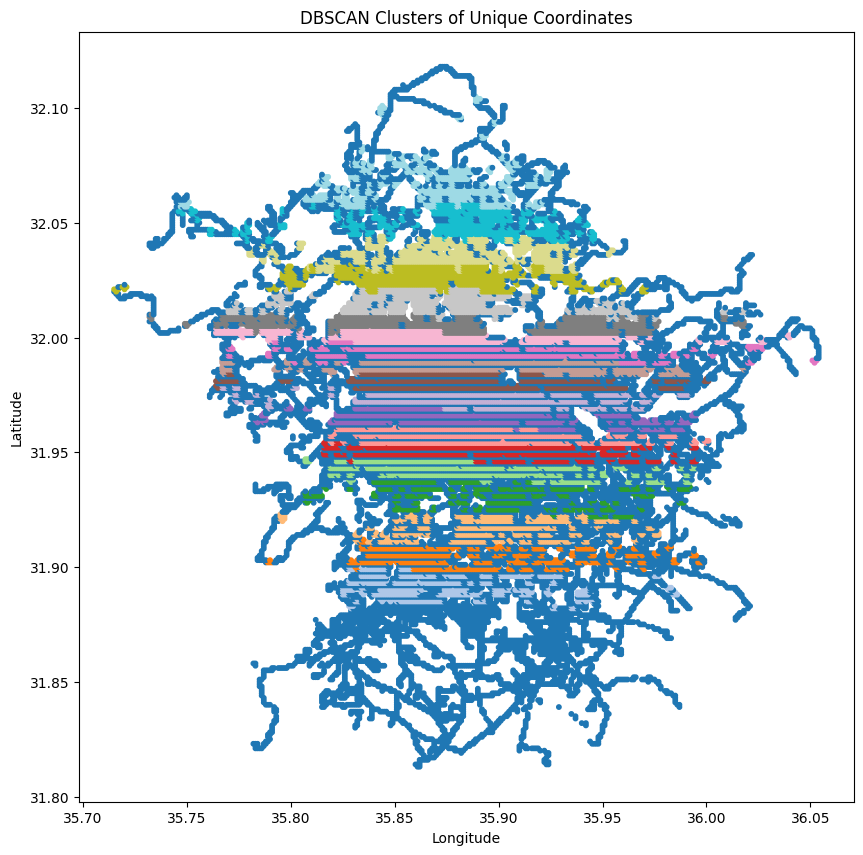

In [ ]:
print(cluster_labels)
# Plot the clusters
plt.figure(figsize=(10, 10))
plt.scatter(unique_coords[:, 1], unique_coords[:, 0], c=cluster_labels, cmap='tab20', s=10)
plt.title('DBSCAN Clusters of Unique Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
# Count the number of points in each cluster using collections.Counter
cluster_counts = collections.Counter(cluster_labels)

# Print the number of points per cluster
print(f"Number of points per cluster:")
for cluster_label, count in cluster_counts.items():
    if cluster_label == -1:
        print(f"Noise (-1): {count} points")
    else:
        print(f"Cluster {cluster_label}: {count} points")


Number of points per cluster:
Noise (-1): 13335 points
Cluster 0: 4 points
Cluster 1: 4 points
Cluster 2: 6 points
Cluster 3: 4 points
Cluster 5: 4 points
Cluster 4: 6 points
Cluster 7: 4 points
Cluster 6: 6 points
Cluster 8: 4 points
Cluster 10: 4 points
Cluster 11: 4 points
Cluster 12: 4 points
Cluster 13: 4 points
Cluster 9: 4 points
Cluster 14: 4 points
Cluster 15: 4 points
Cluster 16: 4 points
Cluster 17: 7 points
Cluster 18: 2 points
Cluster 19: 4 points
Cluster 21: 4 points
Cluster 20: 6 points
Cluster 22: 4 points
Cluster 23: 4 points
Cluster 24: 4 points
Cluster 25: 4 points
Cluster 26: 4 points
Cluster 31: 4 points
Cluster 32: 4 points
Cluster 27: 4 points
Cluster 33: 4 points
Cluster 28: 6 points
Cluster 29: 6 points
Cluster 30: 4 points
Cluster 34: 6 points
Cluster 35: 6 points
Cluster 38: 4 points
Cluster 36: 4 points
Cluster 37: 4 points
Cluster 39: 6 points
Cluster 40: 6 points
Cluster 43: 4 points
Cluster 41: 6 points
Cluster 42: 6 points
Cluster 44: 4 points
Cluster 45

In [ ]:
labels = cluster_labels

#### Evaluate the Clustering Performance

##### Silhouette Score

In [ ]:
# Filter out noise points (-1 labels) before calculating silhouette score
core_samples_mask = labels != -1

if len(set(labels[core_samples_mask])) > 1:  # Check if there are more than 1 cluster
    silhouette_avg = silhouette_score(unique_coords[core_samples_mask], labels[core_samples_mask])
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print("Not enough clusters to calculate silhouette score")


Silhouette Score: 0.3796475764636876


##### Number of Clusters and Noise Points

In [ ]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Subtract 1 if -1 (noise) is present
n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')


Estimated number of clusters: 2470
Estimated number of noise points: 13335


##### Davies-Bouldin Index

In [ ]:
# Exclude noise points
if len(set(labels[core_samples_mask])) > 1:
    dbi_score = davies_bouldin_score(unique_coords[core_samples_mask], labels[core_samples_mask])
    print(f'Davies-Bouldin Index: {dbi_score}')
else:
    print("Not enough clusters to calculate Davies-Bouldin Index")


Davies-Bouldin Index: 0.6743682741476693


##### Manual Inspection (Visual Evaluation)

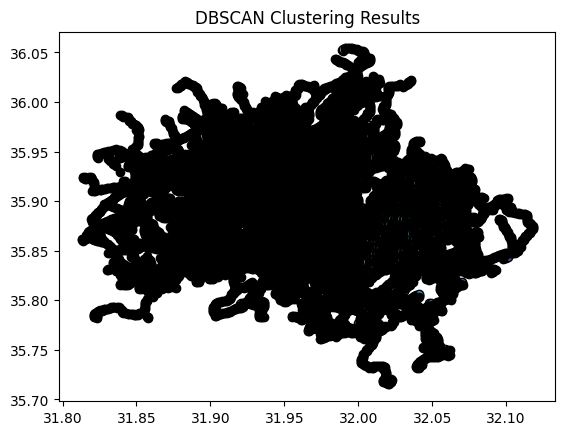

In [ ]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = unique_coords[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering Results')
plt.show()


#### Visualizing the clusters

In [ ]:
# Create a folium map centered around the average coordinates of your data
avg_lat = np.mean(unique_coords[:, 0])
avg_lon = np.mean(unique_coords[:, 1])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Get unique labels (clusters) excluding noise points (-1)
unique_labels = set(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))  # Generate colors for each cluster
for label, color in zip(unique_labels, colors):
    if label == -1:  # Skip noise points
        continue
    cluster_points = unique_coords[cluster_labels == label]

    # Check if cluster has more than 2 points for the convex hull
    if len(cluster_points) > 2:
        hull = MultiPoint(cluster_points).convex_hull

        # Handle different geometry types (Polygon, LineString, or Point)
        if isinstance(hull, Polygon):
            hull_coords = list(hull.exterior.coords)
            # Swap coordinates (lat, lon) -> (lon, lat) for folium
            folium.Polygon(locations=[(lon, lat) for lon, lat in hull_coords],
                           color=mcolors.rgb2hex(color), fill=True, fill_opacity=0.4,
                           tooltip=f'Cluster {label}').add_to(m)

        elif isinstance(hull, LineString):
            hull_coords = list(hull.coords)
            # Swap coordinates (lat, lon) -> (lon, lat) for folium
            folium.PolyLine(locations=[(lon, lat) for lon, lat in hull_coords],
                            color=mcolors.rgb2hex(color), weight=3, opacity=0.7,
                            tooltip=f'Cluster {label} (Line)').add_to(m)

        elif isinstance(hull, Point):
            # Add the point to the folium map (swapping lon, lat to lat, lon)
            folium.Marker(location=[hull.y, hull.x],
                          icon=folium.Icon(color="blue"),
                          tooltip=f'Cluster {label} (Point)').add_to(m)


m.save('DBSCAN/DBSCAN_clusters_map.html')
print("Map with cluster regions saved as 'DBSCAN_clusters_map.html'.")


Map with cluster regions saved as 'DBSCAN_clusters_map.html'.


In [ ]:
# Create a folium map centered around the average coordinates of your data
avg_lat = np.mean(unique_coords[:, 0])
avg_lon = np.mean(unique_coords[:, 1])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Get unique labels (clusters) including noise points (-1)
unique_labels = set(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels) - 1))  # Exclude noise from color mapping

# Plot clusters and handle noise separately
for label, color in zip([l for l in unique_labels if l != -1], colors):
    cluster_points = unique_coords[cluster_labels == label]

    # Convex hull calculation for clusters with more than 2 points
    if len(cluster_points) > 2:
        hull = MultiPoint(cluster_points).convex_hull

        if isinstance(hull, Polygon):
            hull_coords = list(hull.exterior.coords)
            folium.Polygon(locations=[(lon, lat) for lon, lat in hull_coords],
                           color=mcolors.rgb2hex(color), fill=True, fill_opacity=0.4,
                           tooltip=f'Cluster {label}').add_to(m)

        elif isinstance(hull, LineString):
            hull_coords = list(hull.coords)
            folium.PolyLine(locations=[(lon, lat) for lon, lat in hull_coords],
                            color=mcolors.rgb2hex(color), weight=3, opacity=0.7,
                            tooltip=f'Cluster {label} (Line)').add_to(m)

        elif isinstance(hull, Point):
            # Add the point to the folium map (swapping lon, lat to lat, lon)
            folium.Marker(location=[hull.y, hull.x],
                          icon=folium.Icon(color="blue"),
                          tooltip=f'Cluster {label} (Point)').add_to(m)

# Plot the noise points (-1) in a different color
noise_points = unique_coords[cluster_labels == -1]
for coord in noise_points:
    lat, lon = coord[0], coord[1]  # Assuming lat is the first column and lon is the second
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color="gray",  # Gray color for noise points
        fill=True,
        fill_opacity=0.5,
        tooltip='Noise'
    ).add_to(m)

m.save('DBSCAN/DBSCAN_clusters_map_with_noise.html')
print("Map with clusters and noise saved as 'DBSCAN_clusters_map_with_noise.html'.")


Map with clusters and noise saved as 'DBSCAN_clusters_map_with_noise.html'.


#### Visualize the coords pre-clustering

In [ ]:
# Create a folium map centered around the average coordinates of your data
avg_lat = np.mean(unique_coords[:, 0])
avg_lon = np.mean(unique_coords[:, 1])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Plot each point in unique_coords on the map
for coord in unique_coords:
    lat, lon = coord[0], coord[1]  # Swap lat/lon if necessary
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,  # Small radius for individual points
        color="blue",  # Blue color for unclustered points
        fill=True,
        fill_opacity=0.5
    ).add_to(m)

m.save('Raw_Coordinates_Map.html')
print("Map with raw coordinates saved as 'Raw_Coordinates_Map.html'.")


Map with raw coordinates saved as 'Raw_Coordinates_Map.html'.


### Grid Based Clustering

#### STING

In [ ]:
def sting_clustering(coords, grid_size=0.005):
    # Create grid cells by binning the lat/lng coordinates
    lat_bins = np.arange(min(coords[:, 0]), max(coords[:, 0]) + grid_size, grid_size)
    lon_bins = np.arange(min(coords[:, 1]), max(coords[:, 1]) + grid_size, grid_size)

    # Assign each point to a grid cell (using binning)
    lat_grid = np.digitize(coords[:, 0], lat_bins)
    lon_grid = np.digitize(coords[:, 1], lon_bins)

    # Combine lat_grid and lon_grid to create unique grid cell IDs
    grid_cells = np.vstack((lat_grid, lon_grid)).T
    unique_cells = np.unique(grid_cells, axis=0)

    # Cluster points within each cell using KMeans
    cluster_labels = np.zeros(len(coords)) - 1  # Initialize as noise (-1)
    cluster_id = 0

    for cell in unique_cells:
        cell_mask = (lat_grid == cell[0]) & (lon_grid == cell[1])
        cell_points = coords[cell_mask]

        if len(cell_points) > 5:  # Only cluster if there are enough points
            kmeans = KMeans(n_clusters=2)  # You can adjust the number of clusters per grid cell
            labels = kmeans.fit_predict(cell_points)
            cluster_labels[cell_mask] = labels + cluster_id
            cluster_id += 2  # Increment cluster ID

    return cluster_labels

# Apply STING clustering
sting_labels = sting_clustering(unique_coords, grid_size=0.005)

# Visualize STING clusters on a folium map
def visualize_clusters_on_map(coords, labels):
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    m = folium.Map(location=[np.mean(coords[:, 0]), np.mean(coords[:, 1])], zoom_start=12)

    for label, color in zip(unique_labels, colors):
        cluster_points = coords[labels == label]
        for coord in cluster_points:
            lat, lon = coord[0], coord[1]
            folium.CircleMarker(
                location=[lat, lon],
                radius=2,
                color=mcolors.rgb2hex(color),
                fill=True,
                fill_opacity=0.5
            ).add_to(m)

    # Save the map
    m.save('sting_clusters_map_005.html')
    print(f"STING Clustering: Map saved to 'sting_clusters_map.html'")
    return m

# Visualize STING results
m = visualize_clusters_on_map(unique_coords, sting_labels)

# Evaluate STING Clustering
print(f'Number of clusters: {len(set(sting_labels)) - (1 if -1 in sting_labels else 0)}')
print(f'Number of noise points: {np.sum(sting_labels == -1)}')


STING Clustering: Map saved to 'sting_clusters_map.html'
Number of clusters: 3266
Number of noise points: 1211


In [ ]:
# Create a folium map centered around the average coordinates of your data
avg_lat = np.mean(unique_coords[:, 0])
avg_lon = np.mean(unique_coords[:, 1])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Get unique labels (clusters) including noise points (-1)
unique_labels = set(sting_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels) - 1))  # Exclude noise from color mapping

# Plot clusters and handle noise separately
for label, color in zip([l for l in unique_labels if l != -1], colors):
    cluster_points = unique_coords[sting_labels == label]

    # Convex hull calculation for clusters with more than 2 points
    if len(cluster_points) > 2:
        hull = MultiPoint(cluster_points).convex_hull

        if isinstance(hull, Polygon):
            hull_coords = list(hull.exterior.coords)
            folium.Polygon(locations=[(lon, lat) for lon, lat in hull_coords],
                           color=mcolors.rgb2hex(color), fill=True, fill_opacity=0.4,
                           tooltip=f'Cluster {label}').add_to(m)

        elif isinstance(hull, LineString):
            hull_coords = list(hull.coords)
            folium.PolyLine(locations=[(lon, lat) for lon, lat in hull_coords],
                            color=mcolors.rgb2hex(color), weight=3, opacity=0.7,
                            tooltip=f'Cluster {label} (Line)').add_to(m)

        elif isinstance(hull, Point):
            # Add the point to the folium map (swapping lon, lat to lat, lon)
            folium.Marker(location=[hull.y, hull.x],
                          icon=folium.Icon(color="blue"),
                          tooltip=f'Cluster {label} (Point)').add_to(m)

# Plot the noise points (-1) in a different color
noise_points = unique_coords[sting_labels == -1]
for coord in noise_points:
    lat, lon = coord[0], coord[1]  # Assuming lat is the first column and lon is the second
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color="gray",  # Gray color for noise points
        fill=True,
        fill_opacity=0.5,
        tooltip='Noise'
    ).add_to(m)

m.save('STING_005_clusters_map_with_noise.html')
print("Map with clusters and noise saved as 'DBSCAN_clusters_map_with_noise.html'.")


Map with clusters and noise saved as 'DBSCAN_clusters_map_with_noise.html'.


#### CLIQUE

In [ ]:
def clique_clustering(coords, n_bins=70):
    # Discretize the latitude and longitude into n_bins
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    binned_coords = discretizer.fit_transform(coords)

    # Identify dense regions (bins with more than a threshold number of points)
    unique_bins, counts = np.unique(binned_coords, axis=0, return_counts=True)

    # Set a threshold for minimum points in a dense region
    threshold = 3
    dense_regions = unique_bins[counts > threshold]

    # Assign cluster labels based on bin membership
    cluster_labels = np.zeros(len(coords)) - 1  # Initialize as noise (-1)

    for i, coord in enumerate(binned_coords):
        for region in dense_regions:
            if np.array_equal(coord, region):
                cluster_labels[i] = np.where(np.all(dense_regions == region, axis=1))[0][0]

    return cluster_labels

# Apply CLIQUE clustering
clique_labels = clique_clustering(unique_coords, n_bins=70)

# Visualize CLIQUE clusters on a folium map
m = visualize_clusters_on_map(unique_coords, clique_labels)

# Evaluate CLIQUE Clustering
print(f'Number of clusters: {len(set(clique_labels)) - (1 if -1 in clique_labels else 0)}')
print(f'Number of noise points: {np.sum(clique_labels == -1)}')


STING Clustering: Map saved to 'sting_clusters_map.html'
Number of clusters: 2038
Number of noise points: 567


threshold = 5 an n bins = 70

In [ ]:
# Create a folium map centered around the average coordinates of your data
avg_lat = np.mean(unique_coords[:, 0])
avg_lon = np.mean(unique_coords[:, 1])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Get unique labels (clusters) including noise points (-1)
unique_labels = set(clique_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels) - 1))  # Exclude noise from color mapping

# Plot clusters and handle noise separately
for label, color in zip([l for l in unique_labels if l != -1], colors):
    cluster_points = unique_coords[clique_labels == label]

    # Convex hull calculation for clusters with more than 2 points
    if len(cluster_points) > 2:
        hull = MultiPoint(cluster_points).convex_hull

        if isinstance(hull, Polygon):
            hull_coords = list(hull.exterior.coords)
            folium.Polygon(locations=[(lon, lat) for lon, lat in hull_coords],
                           color=mcolors.rgb2hex(color), fill=True, fill_opacity=0.4,
                           tooltip=f'Cluster {label}').add_to(m)

        elif isinstance(hull, LineString):
            hull_coords = list(hull.coords)
            folium.PolyLine(locations=[(lon, lat) for lon, lat in hull_coords],
                            color=mcolors.rgb2hex(color), weight=3, opacity=0.7,
                            tooltip=f'Cluster {label} (Line)').add_to(m)

        elif isinstance(hull, Point):
            # Add the point to the folium map (swapping lon, lat to lat, lon)
            folium.Marker(location=[hull.y, hull.x],
                          icon=folium.Icon(color="blue"),
                          tooltip=f'Cluster {label} (Point)').add_to(m)

# Plot the noise points (-1) in a different color
noise_points = unique_coords[clique_labels == -1]
for coord in noise_points:
    lat, lon = coord[0], coord[1]  # Assuming lat is the first column and lon is the second
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color="gray",  # Gray color for noise points
        fill=True,
        fill_opacity=0.5,
        tooltip='Noise'
    ).add_to(m)


m.save('CLIQUE_70_3_clusters_map_with_noise.html')
print("Map with clusters and noise saved.")


Map with clusters and noise saved.


### Hierarchical Clustering - Agglomerative

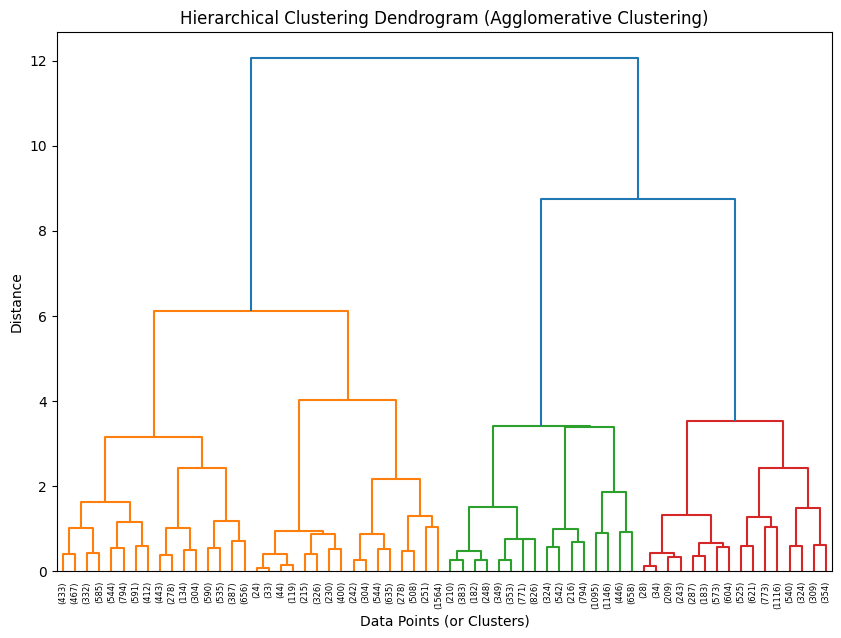

Number of clusters: 2412


In [ ]:
distance_threshold = 0.009  # Adjust based on your data (in degrees)
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold)
hierarchical_labels = agg_clustering.fit_predict(unique_coords)

# Visualize the Dendrogram using Scipy's `linkage` function
# The linkage method requires pairwise distances, so we'll compute them

# Compute linkage matrix based on pairwise distances
Z = linkage(unique_coords, method='ward')  # 'ward' minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram (Agglomerative Clustering)')
plt.xlabel('Data Points (or Clusters)')
plt.ylabel('Distance')
dendrogram(Z, truncate_mode='level', p=5)  # Show the top 5 levels of hierarchy
plt.show()

n_clusters = len(set(hierarchical_labels))
print(f'Number of clusters: {n_clusters}')


In [ ]:
# Create a folium map centered around the average coordinates of your data
avg_lat = np.mean(unique_coords[:, 0])
avg_lon = np.mean(unique_coords[:, 1])
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Get unique labels (clusters) including noise points (-1)
unique_labels = set(hierarchical_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels) - 1))  # Exclude noise from color mapping

# Plot clusters and handle noise separately
for label, color in zip([l for l in unique_labels if l != -1], colors):
    cluster_points = unique_coords[hierarchical_labels == label]

    # Convex hull calculation for clusters with more than 2 points
    if len(cluster_points) > 2:
        hull = MultiPoint(cluster_points).convex_hull

        if isinstance(hull, Polygon):
            hull_coords = list(hull.exterior.coords)
            folium.Polygon(locations=[(lon, lat) for lon, lat in hull_coords],
                           color=mcolors.rgb2hex(color), fill=True, fill_opacity=0.4,
                           tooltip=f'Cluster {label}').add_to(m)

        elif isinstance(hull, LineString):
            hull_coords = list(hull.coords)
            folium.PolyLine(locations=[(lon, lat) for lon, lat in hull_coords],
                            color=mcolors.rgb2hex(color), weight=3, opacity=0.7,
                            tooltip=f'Cluster {label} (Line)').add_to(m)

        elif isinstance(hull, Point):
            # Add the point to the folium map (swapping lon, lat to lat, lon)
            folium.Marker(location=[hull.y, hull.x],
                          icon=folium.Icon(color="blue"),
                          tooltip=f'Cluster {label} (Point)').add_to(m)

# Plot the noise points (-1) in a different color
noise_points = unique_coords[hierarchical_labels == -1]
for coord in noise_points:
    lat, lon = coord[0], coord[1]  # Assuming lat is the first column and lon is the second
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color="gray",  # Gray color for noise points
        fill=True,
        fill_opacity=0.5,
        tooltip='Noise'
    ).add_to(m)


m.save('hierarchical_clusters_map_with_noise_009.html')
print("Map with clusters and noise saved.")


Map with clusters and noise saved.


## Pattern among trips using the different clustering methods

In [ ]:
len(hierarchical_labels)

28468

In [ ]:
unique_labels = set(hierarchical_labels)
len(unique_labels)

2412

In [ ]:
# List of clustering labels and their corresponding names
clustering_algorithms = {
    'dbscan': cluster_labels,
    'sting': sting_labels,
    'clique': clique_labels,
    'hierarchical': hierarchical_labels
}

# General function to map coordinates to clusters and assign start/end cluster for each algorithm
def assign_clusters(road_df, coords, clustering_labels, label_name):
    coord_to_cluster = dict(zip(map(tuple, coords), clustering_labels))

    def get_cluster_id(lat, lon):
        return coord_to_cluster.get((lat, lon), None)

    # Assign start and end clusters for the current algorithm
    road_df[f'start_cluster_{label_name}'] = [get_cluster_id(row['lats'][0], row['lngs'][0]) for _, row in road_df.iterrows()]
    road_df[f'end_cluster_{label_name}'] = [get_cluster_id(row['lats'][-1], row['lngs'][-1]) for _, row in road_df.iterrows()]
    road_df[f'same_cluster_{label_name}'] = road_df[f'start_cluster_{label_name}'] == road_df[f'end_cluster_{label_name}']

# Apply the function for each algorithm
for label_name, clustering_labels in clustering_algorithms.items():
    assign_clusters(road_df, coords, clustering_labels, label_name)


In [ ]:
# Define 2-hour segment ranges (in minutes)
two_hour_segments = [(i * 120, (i + 1) * 120) for i in range(12)]  # Each tuple is a (start, end) range in minutes
two_hour_labels = [f"{str(i*2).zfill(2)}:00 - {str(i*2+2).zfill(2)}:00" for i in range(12)]  # Two-hour labels in "HH:MM - HH:MM" format

# Function to determine which 2-hour segment a timeID belongs to
def get_two_hour_segment(timeID):
    for idx, (start, end) in enumerate(two_hour_segments):
        if start <= timeID < end:
            return two_hour_labels[idx]  # Return the corresponding 2-hour label
    return None  # Return None if the timeID is outside the 0-1440 range (but it shouldn't happen)

# Apply the 2-hour segment function to assign each row to a 2-hour segment based on timeID
road_df['two_hour_segment'] = road_df['timeID'].apply(get_two_hour_segment)


In [ ]:
# Define a list to store results for all clustering algorithms
final_trip_categories = []

# Iterate over each algorithm to process trips
for label_name in clustering_algorithms.keys():
    if label_name == 'hierarchical':
        # Filter entries where the start and end clusters are different
        df_diff_clusters = road_df[road_df[f'same_cluster_{label_name}'] == False]

        # Group trips by start cluster and end cluster
        trip_categories = df_diff_clusters.groupby([f'start_cluster_{label_name}', f'end_cluster_{label_name}']).apply(lambda x: x['trip_id'].tolist())

        # Print categorized trips
        print(f"Categorized trips for {label_name}:")
        for (start_cluster, end_cluster), trips in trip_categories.items():
            print(f"From cluster {start_cluster} to cluster {end_cluster}: {len(trips)} trips - {trips}")

        # Create a unique identifier for each trip by combining 'trip_id' and 'segmentID'
        df_diff_clusters['unique_trip'] = df_diff_clusters['trip_id'].astype(str) + '_' + df_diff_clusters['segmentID'].astype(str)

        # Group trips by start cluster, end cluster, and two-hour segment
        trip_categories = df_diff_clusters.groupby([f'start_cluster_{label_name}', f'end_cluster_{label_name}', 'two_hour_segment']).apply(lambda x: x['unique_trip'].tolist())
        rows_list = []

        # Populate the list with the categorized trip information including time
        for (start_cluster, end_cluster, segment), trips in trip_categories.items():
            if len(trips) > 1:
                # Extract the 'time' for the corresponding trips
                trip_times = df_diff_clusters[df_diff_clusters['unique_trip'].isin(trips)]['trip_time'].tolist()

                # Calculate variance and standard deviation for trip times
                if trip_times:
                    variance = np.var(trip_times) / (60**2)  # Variance in minutes
                    std_dev = np.std(trip_times) / 60        # Standard deviation in minutes
                else:
                    variance = None
                    std_dev = None

                rows_list.append({
                    'start_cluster': start_cluster,
                    'end_cluster': end_cluster,
                    'two_hour_segment': segment,
                    'trip_count': len(trips),
                    'trip_times': trip_times,
                    'variance': round(variance, 3),
                    'std': round(std_dev, 3),
                    'trip_ids': trips
                })

        # Store the results for the current algorithm
        trip_categories_df = pd.DataFrame(rows_list)
        
        output_csv = f'Clustered_Segmented_Trip_Variances_{label_name}_009.csv'
        trip_categories_df.to_csv(output_csv, index=False)

        print(f"Filtered trip categories for {label_name} with more than 1 trip saved to {output_csv}")

<ipython-input-62-6a6cee03169c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_categories = df_diff_clusters.groupby([f'start_cluster_{label_name}', f'end_cluster_{label_name}']).apply(lambda x: x['trip_id'].tolist())


Streaming output truncated to the last 5000 lines.
From cluster 1437.0 to cluster 730.0: 1 trips - ['f6dfb0951289a744eec79efcfaa9d67aa430cf46c0caf6d07619d9ba155980f8']
From cluster 1437.0 to cluster 732.0: 3 trips - ['07c8f0fc55323a6286048c7ab6b36a3ee9bc36d17286de885d1e51bb37f8c11e', '217ce14344a20ecb580e1e776006d072f4319bb05741d9e58560f6690dcee321', '54c1b7aced7c0e6fa574cbb8bd83f0185e315178902a89ca79c2517ab45f3e04']
From cluster 1437.0 to cluster 1245.0: 1 trips - ['a977c4ca48a03f59870cdb081e235639bb6f3af243ba42d8931f1306f2c1520b']
From cluster 1437.0 to cluster 1413.0: 1 trips - ['a50ffba7573a857e8d0c5e3e69e929a90fb027a4baa51ed3ec045cbec73c0b04']
From cluster 1437.0 to cluster 1911.0: 2 trips - ['7ebef0fb3e0429402d40f2fa4a8528c0ed38edf76d6b355937c463deaca08d89', '5e6dd78436d33cfbd1c6bffae593a8d2373c398289a145c18495cbbcb495c25a']
From cluster 1437.0 to cluster 2254.0: 1 trips - ['339e2f75302c9776345ecc9abe04c18b44a9501532367e6b70e65db8475a1b0b']
From cluster 1438.0 to cluster 245.0: 1

<ipython-input-62-6a6cee03169c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff_clusters['unique_trip'] = df_diff_clusters['trip_id'].astype(str) + '_' + df_diff_clusters['segmentID'].astype(str)
<ipython-input-62-6a6cee03169c>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trip_categories = df_diff_clusters.groupby([f'start_cluster_{label_name}', f'end_cluster_{label_name}', 'two_hour_segment']).apply(lambda x: x['unique_trip'].tolist())


Filtered trip categories for hierarchical with more than 1 trip saved to Clustered_Segmented_Trip_Variances_hierarchical_009.csv


## Modeling with RFR

In [ ]:
time_segment_mapping = {
    '00:00 - 02:00': 0,
    '02:00 - 04:00': 1,
    '04:00 - 06:00': 2,
    '06:00 - 08:00': 3,
    '08:00 - 10:00': 4,
    '10:00 - 12:00': 5,
    '12:00 - 14:00': 6,
    '14:00 - 16:00': 7,
    '16:00 - 18:00': 8,
    '18:00 - 20:00': 9,
    '20:00 - 22:00': 10,
    '22:00 - 24:00': 11
}

road_df['two_hour_segment_encoded'] = road_df['two_hour_segment'].map(time_segment_mapping)
print(road_df[['two_hour_segment', 'two_hour_segment_encoded']].head())


  two_hour_segment  two_hour_segment_encoded
0    10:00 - 12:00                         5
1    20:00 - 22:00                        10
2    20:00 - 22:00                        10
3    22:00 - 24:00                        11
4    12:00 - 14:00                         6


In [ ]:
road_df['two_hour_segment'].unique()

array(['10:00 - 12:00', '20:00 - 22:00', '22:00 - 24:00', '12:00 - 14:00',
       '14:00 - 16:00', '18:00 - 20:00', '16:00 - 18:00', '06:00 - 08:00',
       '08:00 - 10:00', '04:00 - 06:00', '00:00 - 02:00', '02:00 - 04:00'],
      dtype=object)

### RFR Training for all Clustering Algorithms with Random Parameter Search

Dump Cluster Labels

In [ ]:
def save_coordinate_label_mappings(unique_coords, clustering_algorithms):

    for algorithm, labels in clustering_algorithms.items():
        print(f"Saving coordinate label mapping for {algorithm}")

        # Ensure the number of labels matches the number of unique coordinates
        if len(labels) != len(unique_coords):
            print(f"Mismatch in the number of labels and coordinates for {algorithm}. Skipping.")
            continue

        # Create a mapping of coordinates (as strings) to cluster labels, converting labels to int
        coord_label_mapping = {
            str(tuple(coord)): int(label) for coord, label in zip(unique_coords, labels)
        }

        # Save the mapping to a JSON file
        mapping_filename = f'{algorithm}_coordinate_label_mapping.json'
        with open(mapping_filename, 'w') as mapping_file:
            json.dump(coord_label_mapping, mapping_file, indent=4)
        print(f"Coordinate label mapping for {algorithm} saved to {mapping_filename}")

save_coordinate_label_mappings(unique_coords, clustering_algorithms)


Saving coordinate label mapping for dbscan
Coordinate label mapping for dbscan saved to dbscan_coordinate_label_mapping.json
Saving coordinate label mapping for sting
Coordinate label mapping for sting saved to sting_coordinate_label_mapping.json
Saving coordinate label mapping for clique
Coordinate label mapping for clique saved to clique_coordinate_label_mapping.json
Saving coordinate label mapping for hierarchical
Coordinate label mapping for hierarchical saved to hierarchical_coordinate_label_mapping.json


In [ ]:
road_df.shape

(64442, 30)

Running RFR with random search for clustering algorithm: dbscan
Trained model for dbscan saved as dbscan_best_rfr_model.pkl

Feature Importance for dbscan Model (Best Estimator):
                    feature  importance
0                      dist    0.856167
2                    timeID    0.075441
5      start_cluster_dbscan    0.026399
1                    weekID    0.020944
6        end_cluster_dbscan    0.017293
3                 segmentID    0.002454
4  two_hour_segment_encoded    0.001300


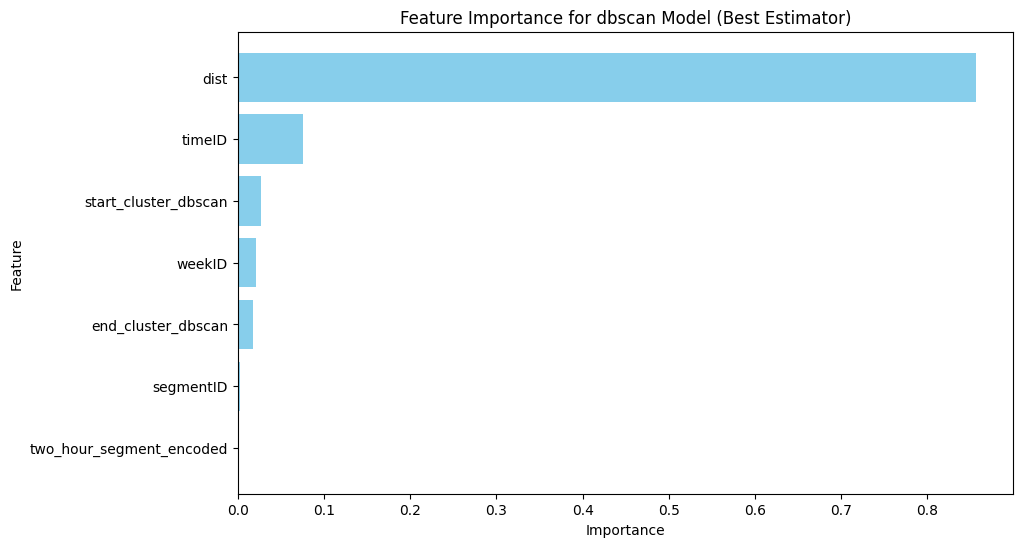

Running RFR with random search for clustering algorithm: hierarchical
Trained model for hierarchical saved as hierarchical_best_rfr_model.pkl

Feature Importance for hierarchical Model (Best Estimator):
                      feature  importance
0                        dist    0.847058
2                      timeID    0.070078
5  start_cluster_hierarchical    0.036073
6    end_cluster_hierarchical    0.023653
1                      weekID    0.019662
3                   segmentID    0.002329
4    two_hour_segment_encoded    0.001146


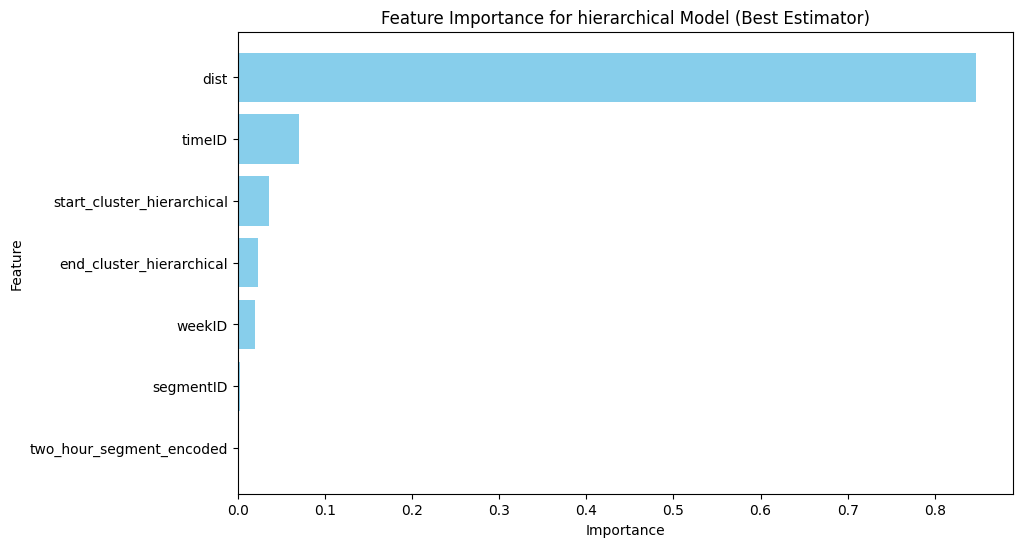

Running RFR with random search for clustering algorithm: sting
Trained model for sting saved as sting_best_rfr_model.pkl

Feature Importance for sting Model (Best Estimator):
                    feature  importance
0                      dist    0.846835
2                    timeID    0.070245
5       start_cluster_sting    0.036152
6         end_cluster_sting    0.023479
1                    weekID    0.019837
3                 segmentID    0.002284
4  two_hour_segment_encoded    0.001168


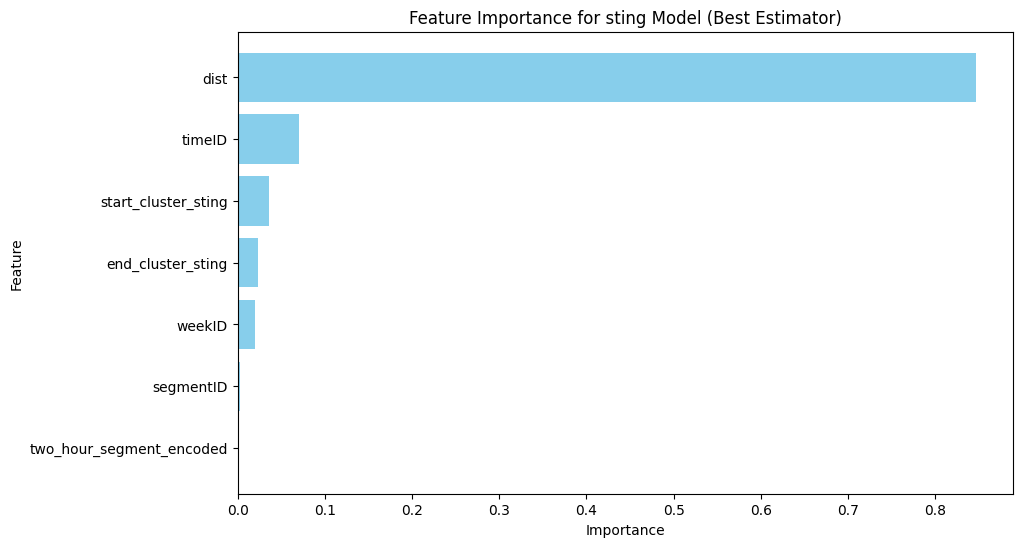

Running RFR with random search for clustering algorithm: clique
Trained model for clique saved as clique_best_rfr_model.pkl

Feature Importance for clique Model (Best Estimator):
                    feature  importance
0                      dist    0.847048
2                    timeID    0.069828
5      start_cluster_clique    0.036437
6        end_cluster_clique    0.023386
1                    weekID    0.019861
3                 segmentID    0.002284
4  two_hour_segment_encoded    0.001156


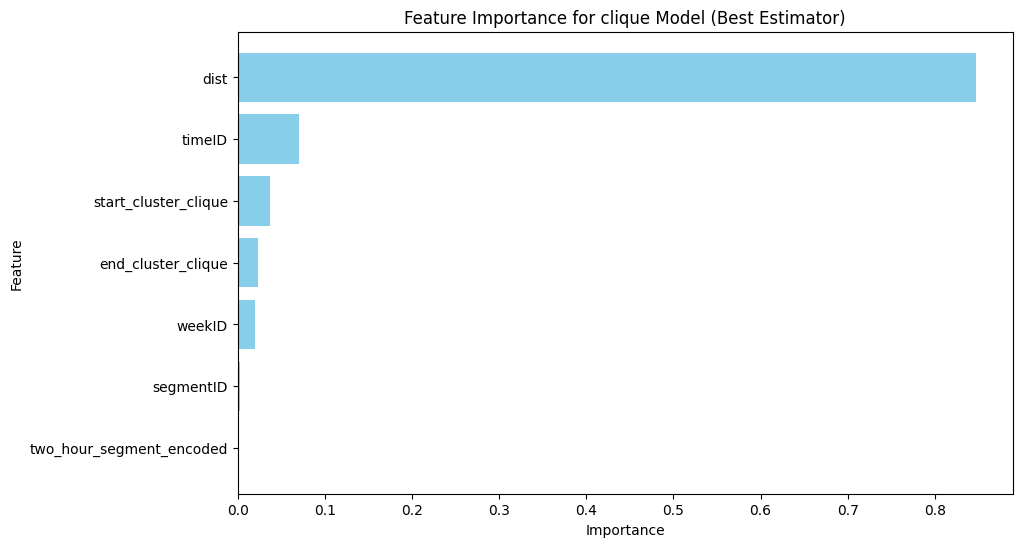

Best hyperparameters saved as 'best_hyperparameters.pkl'
Saving label mapping for dbscan
Column cluster_labels_dbscan not found in road_df. Skipping dbscan.
Saving label mapping for hierarchical
Column cluster_labels_hierarchical not found in road_df. Skipping hierarchical.
Saving label mapping for sting
Column cluster_labels_sting not found in road_df. Skipping sting.
Saving label mapping for clique
Column cluster_labels_clique not found in road_df. Skipping clique.
                                             trip_id  actual_eta  \
0  011332faae79852124ca91fff1ed4757dfa63ede73e595...       567.0   
1  450a8935d83494b0e31c5d294774c604eabced2f757e43...       986.0   
2  b2c5fed728bdbe415900c53f20a98442d71e45da2cf18f...      1088.0   
3  7ad091f5f519dcceb54765b3940e0886ff8d19122da0a0...       735.0   
4  4b6e4fcb77da6638226f70c3b26dcb58a00ead335630f6...       340.0   

   predicted_eta algorithm  
0     413.717812    dbscan  
1     797.190841    dbscan  
2     961.845293    dbscan  
3  

In [ ]:
def run_rfr_with_random_search(road_df, clustering_columns, target_column='trip_time'):
    feature_columns = ['dist', 'weekID', 'timeID', 'segmentID', 'two_hour_segment_encoded']

    all_results = []  # Store results for each algorithm
    metrics = []
    best_params = {}

    param_distributions = {
        'n_estimators': np.arange(50, 300, 50),
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4]
    }

    for algorithm, cluster_col in clustering_columns.items():
        print(f"Running RFR with random search for clustering algorithm: {algorithm}")

        specific_features = feature_columns + [f'start_cluster_{algorithm}', f'end_cluster_{algorithm}']

        missing_columns = [col for col in specific_features if col not in road_df.columns]
        if missing_columns:
            print(f"Missing columns for {algorithm}: {missing_columns}. Skipping this algorithm.")
            continue

        X = road_df[specific_features]
        y = road_df[target_column]
        trip_ids = road_df['trip_id']  # Retain trip_id for traceability in the output

        X_train, X_test, y_train, y_test, trip_id_train, trip_id_test = train_test_split(
            X, y, trip_ids, test_size=0.2, random_state=42
        )

        model = RandomForestRegressor(random_state=42)
        random_search = RandomizedSearchCV(
            estimator=model, param_distributions=param_distributions,
            n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42, n_jobs=-1
        )

        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        best_hyperparameters = random_search.best_params_

        best_params[algorithm] = best_hyperparameters

        model_filename = f'{algorithm}_best_rfr_model.pkl'
        with open(model_filename, 'wb') as model_file:
            pickle.dump(best_model, model_file)
        print(f"Trained model for {algorithm} saved as {model_filename}")

        
        y_pred = best_model.predict(X_test)

        
        rmse = root_mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results = pd.DataFrame({
            'trip_id': trip_id_test,
            'actual_eta': y_test,
            'predicted_eta': y_pred,
            'algorithm': algorithm
        })

        # Store results for the entire algorithm
        metrics.append({
            'algorithm': algorithm,
            'Average_RMSE': rmse,
            'Average_MAE': mae,
            'Average_R2': r2,
            'Best_Hyperparameters': best_hyperparameters
        })

        # Display feature importance
        feature_importance = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': specific_features,
            'importance': feature_importance
        }).sort_values(by='importance', ascending=False)

        print(f"\nFeature Importance for {algorithm} Model (Best Estimator):")
        print(importance_df)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance for {algorithm} Model (Best Estimator)')
        plt.gca().invert_yaxis() 
        plt.show()

        all_results.append(results)

    final_results_df = pd.concat(all_results, ignore_index=True)

    with open('best_hyperparameters.pkl', 'wb') as params_file:
        pickle.dump(best_params, params_file)
    print("Best hyperparameters saved as 'best_hyperparameters.pkl'")

    metrics_df = pd.DataFrame(metrics)
    
    return final_results_df, metrics_df


clustering_columns = {
    'dbscan': 'cluster_labels_dbscan',            
    'hierarchical': 'cluster_labels_hierarchical',
    'sting': 'cluster_labels_sting',              
    'clique': 'cluster_labels_clique'              
}


results_df, metrics_df = run_rfr_with_random_search(road_df, clustering_columns)

print(results_df.head())

output_csv = 'tuned_clustered_trip_eta_predictions_with_trip_id.csv'
results_df.to_csv(output_csv, index=False)
print(f"Results with trip IDs saved to {output_csv}")

print("***************************************")
print("Metrics:")
print(metrics_df)


In [ ]:
# dump road_df to csv
road_df.to_csv('checkpt_road_df.csv', index=False)

In [ ]:
metrics_df.to_csv('random_search_metrics.csv', index = False)

In [ ]:
metrics_df.shape

(4, 5)

In [ ]:
road_df.columns

In [ ]:
road_df['driverID'].nunique()

In [ ]:
# display statistics for each driver
driver_stats = road_df.groupby('driverID')['trip_time'].agg(['count', 'mean', 'std', 'min', 'max'])
driver_stats.head(10)

In [ ]:
road_df['trip_id'].nunique()

## Feature Engineering

### Capturing Drivers' Behavior - Encoding DriverID

#### Analysis

In [ ]:
# what is the number of unique driver id values in the dataset? 
road_df['driverID'].nunique()

3543

In [ ]:
# Group by driverID to calculate statistics
driver_stats = road_df.groupby('driverID').agg(
    trip_count=('trip_time', 'count'),
    mean_trip_time=('trip_time', 'mean'),
    std_trip_time=('trip_time', 'std'),
    total_distance=('dist', 'sum'),
    mean_distance=('dist', 'mean')
).reset_index()

# Display summary statistics
print(driver_stats.head())

# Correlation between trip count and mean trip time
correlation = driver_stats[['trip_count', 'mean_trip_time']].corr()
print("\nCorrelation between trip count and mean trip time:")
print(correlation)


                                            driverID  trip_count  \
0  00026bdabb9ed4160a3e034d3283863a5c068943284a72...          18   
1  000446c37bb324390e0837bb939a4c59c3ac9527f94ffc...           1   
2  000b0c279a96e0d589bd7d0b8e3cd517a16d93767addb5...          34   
3  00148873a62dea02f169caeb7ba055a92e0e328068af7f...           5   
4  0015d25a5ad155bcb44d2eb8c78d36c1194fdccf8ec55e...          17   

   mean_trip_time  std_trip_time  total_distance  mean_distance  
0      547.444444     407.304081       79.387679       4.410427  
1      370.000000            NaN        5.206822       5.206822  
2      648.794118     546.681104      130.160014       3.828236  
3     1022.600000     826.667587       21.002961       4.200592  
4      569.941176     553.541154       60.085096       3.534417  

Correlation between trip count and mean trip time:
                trip_count  mean_trip_time
trip_count        1.000000       -0.111178
mean_trip_time   -0.111178        1.000000


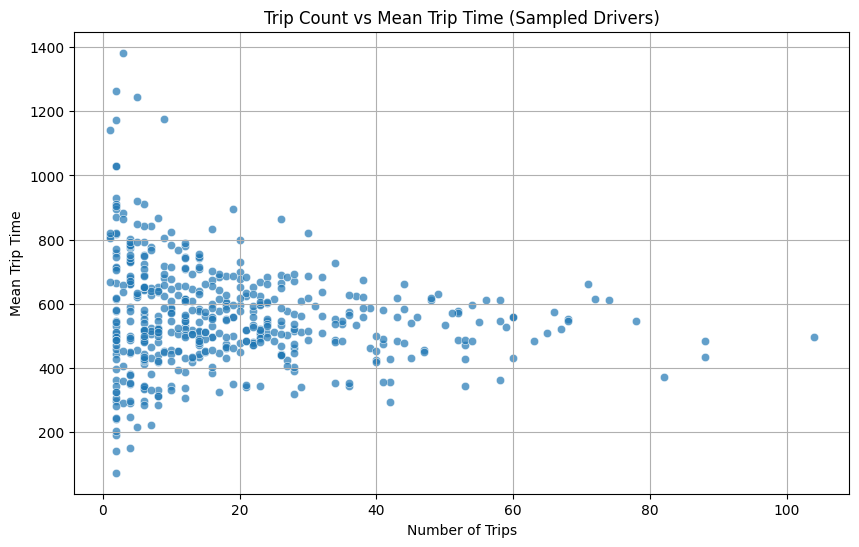

In [ ]:
# Randomly sample 500 drivers for visualization
sampled_driver_stats = driver_stats.sample(500, random_state=42)

# Plot sampled data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled_driver_stats, x='trip_count', y='mean_trip_time', alpha=0.7)
plt.title("Trip Count vs Mean Trip Time (Sampled Drivers)")
plt.xlabel("Number of Trips")
plt.ylabel("Mean Trip Time")
plt.grid()
plt.show()


C:\Users\nadab\AppData\Local\Temp\ipykernel_10604\2833471573.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_data, x='driverID', y='trip_time', palette='Set3')


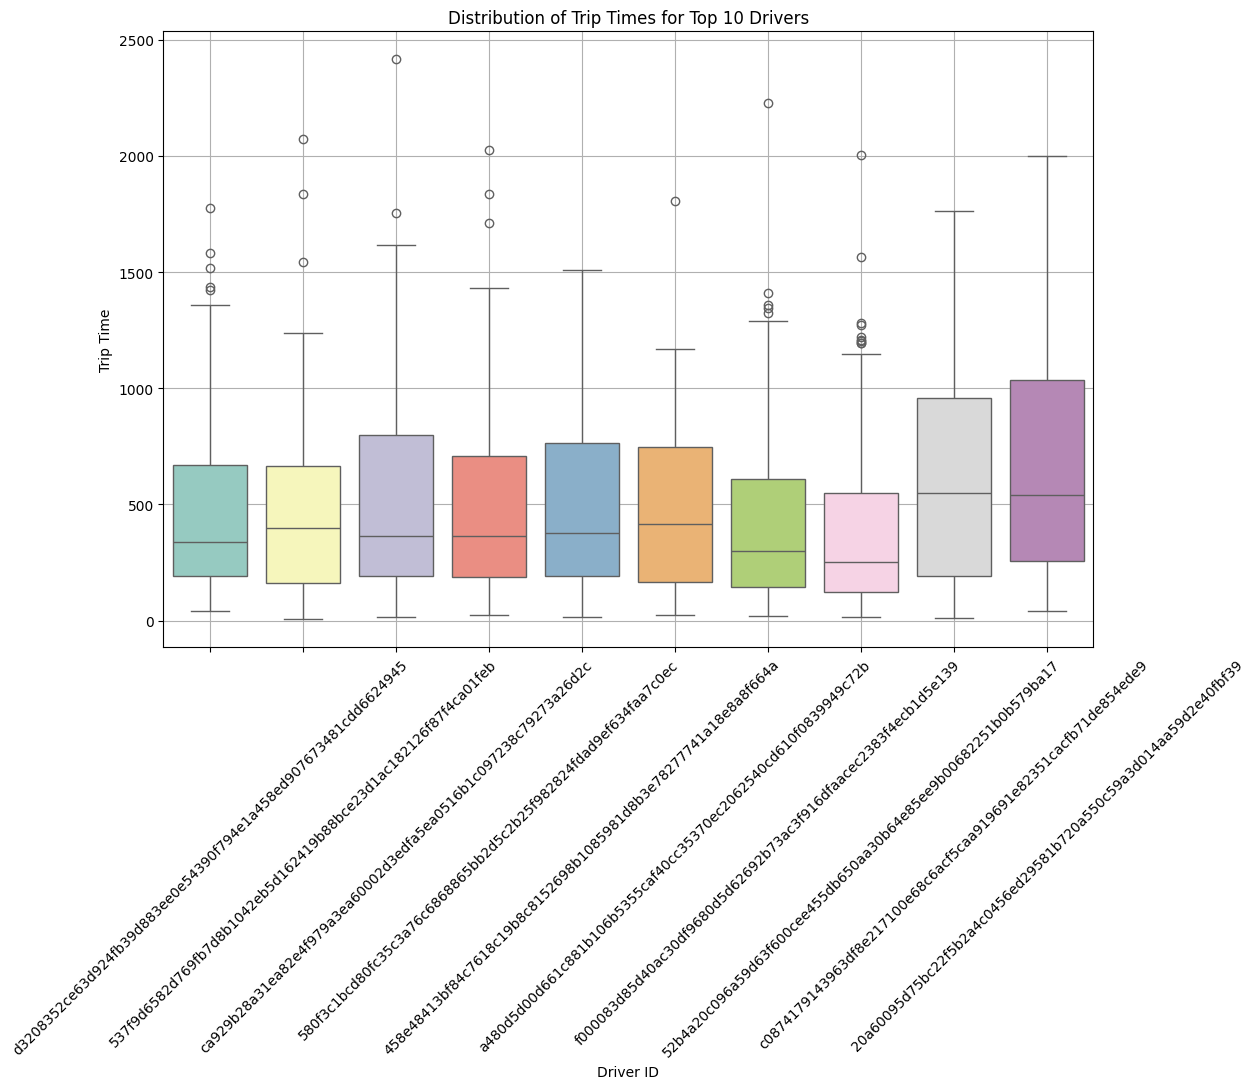

In [ ]:
# Select a subset of drivers for detailed visualization
subset_drivers = road_df['driverID'].value_counts().nlargest(10).index

# Filter the data for these drivers
subset_data = road_df[road_df['driverID'].isin(subset_drivers)]

# Plot trip time distributions for each driver
plt.figure(figsize=(12, 8))
sns.boxplot(data=subset_data, x='driverID', y='trip_time', palette='Set3')
plt.title("Distribution of Trip Times for Top 10 Drivers")
plt.xlabel("Driver ID")
plt.ylabel("Trip Time")
plt.xticks(rotation=45)
plt.grid()
plt.show()


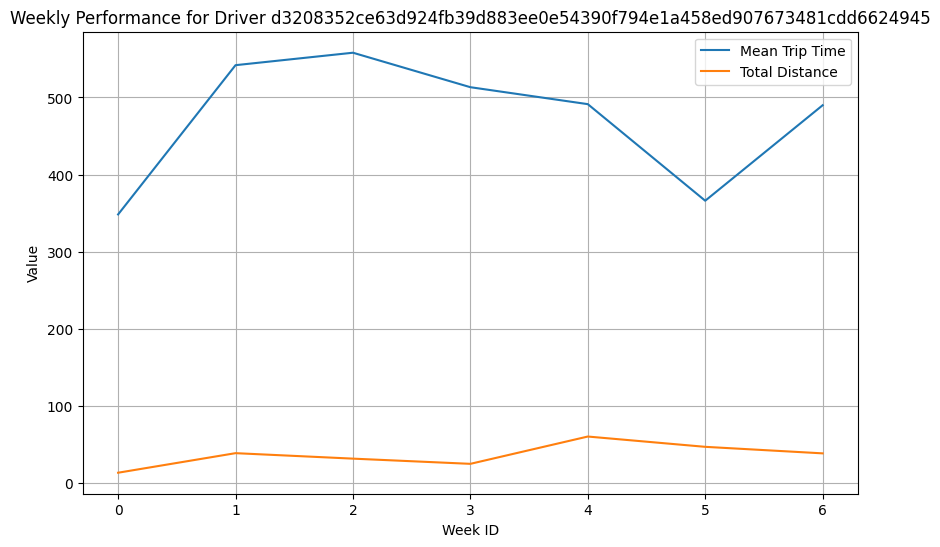

In [ ]:
# Aggregate trip time by driver and week
weekly_performance = road_df.groupby(['driverID', 'weekID']).agg(
    mean_trip_time=('trip_time', 'mean'),
    total_distance=('dist', 'sum')
).reset_index()

# Select a sample driver to visualize over time
sample_driver = subset_drivers[8]  # Pick the first driver
driver_data = weekly_performance[weekly_performance['driverID'] == sample_driver]

# Plot weekly performance for the sample driver
plt.figure(figsize=(10, 6))
sns.lineplot(data=driver_data, x='weekID', y='mean_trip_time', label='Mean Trip Time')
sns.lineplot(data=driver_data, x='weekID', y='total_distance', label='Total Distance')
plt.title(f"Weekly Performance for Driver {sample_driver}")
plt.xlabel("Week ID")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


C:\Users\nadab\AppData\Local\Temp\ipykernel_10604\1589063612.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_data, x='driverID', y='residual', palette='coolwarm')


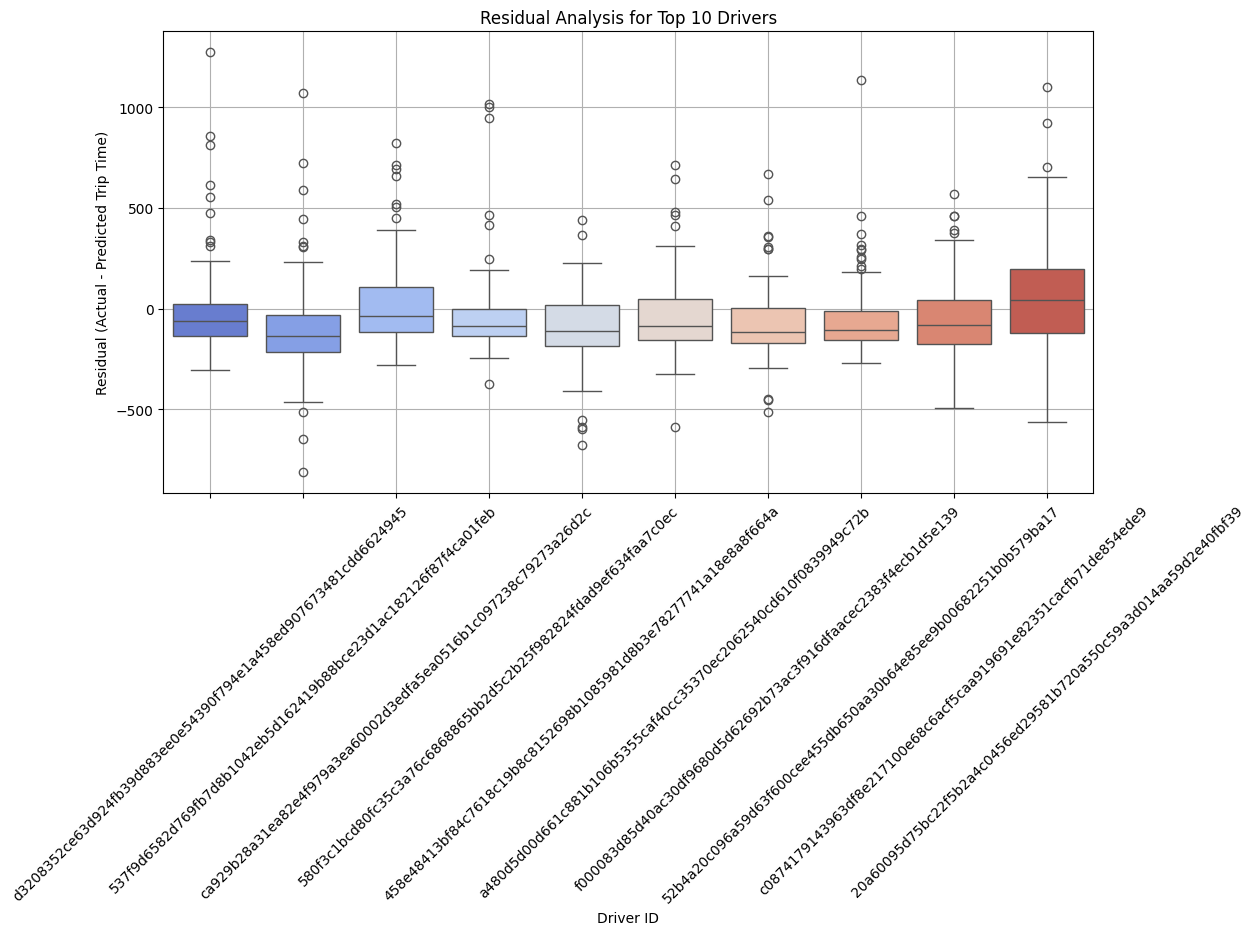

In [ ]:
# Fit a regression model to predict trip time based on distance and other factors
X = road_df[['dist', 'segmentID', 'timeID']]
y = road_df['trip_time']
model = LinearRegression()
model.fit(X, y)
road_df['predicted_trip_time'] = model.predict(X)
road_df['residual'] = road_df['trip_time'] - road_df['predicted_trip_time']

# Plot residuals for the top drivers
subset_data = road_df[road_df['driverID'].isin(subset_drivers)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=subset_data, x='driverID', y='residual', palette='coolwarm')
plt.title("Residual Analysis for Top 10 Drivers")
plt.xlabel("Driver ID")
plt.ylabel("Residual (Actual - Predicted Trip Time)")
plt.xticks(rotation=45)
plt.grid()
plt.show()


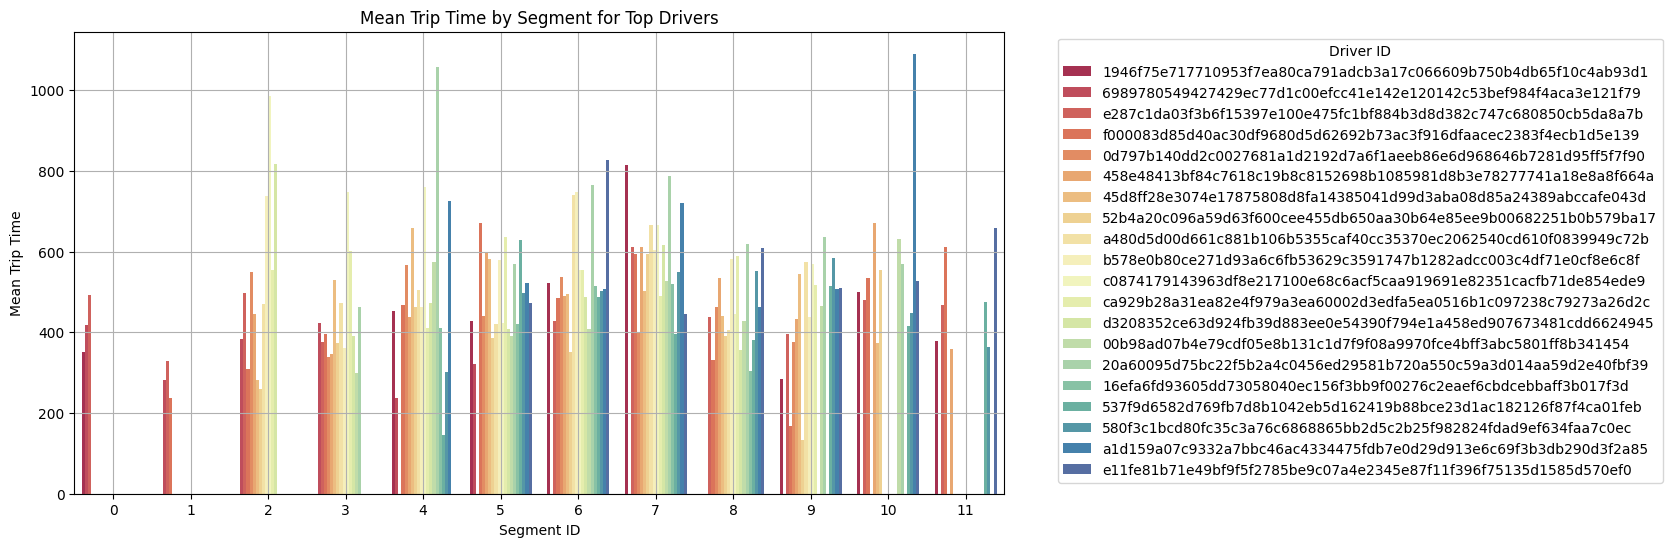

In [ ]:
new_subset_drivers = road_df['driverID'].value_counts().nlargest(20).index

# Group by driverID and segmentID to calculate mean trip time
segment_behavior = road_df.groupby(['driverID', 'two_hour_segment_encoded']).agg(
    mean_trip_time=('trip_time', 'mean'),
    trip_count=('trip_time', 'count')
).reset_index()

# Visualize for top drivers
sampled_segment_data = segment_behavior[segment_behavior['driverID'].isin(new_subset_drivers)]

plt.figure(figsize=(12, 6))
sns.barplot(data=sampled_segment_data, x='two_hour_segment_encoded', y='mean_trip_time', hue='driverID', palette='Spectral')
plt.title("Mean Trip Time by Segment for Top Drivers")
plt.xlabel("Segment ID")
plt.ylabel("Mean Trip Time")
plt.legend(title="Driver ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


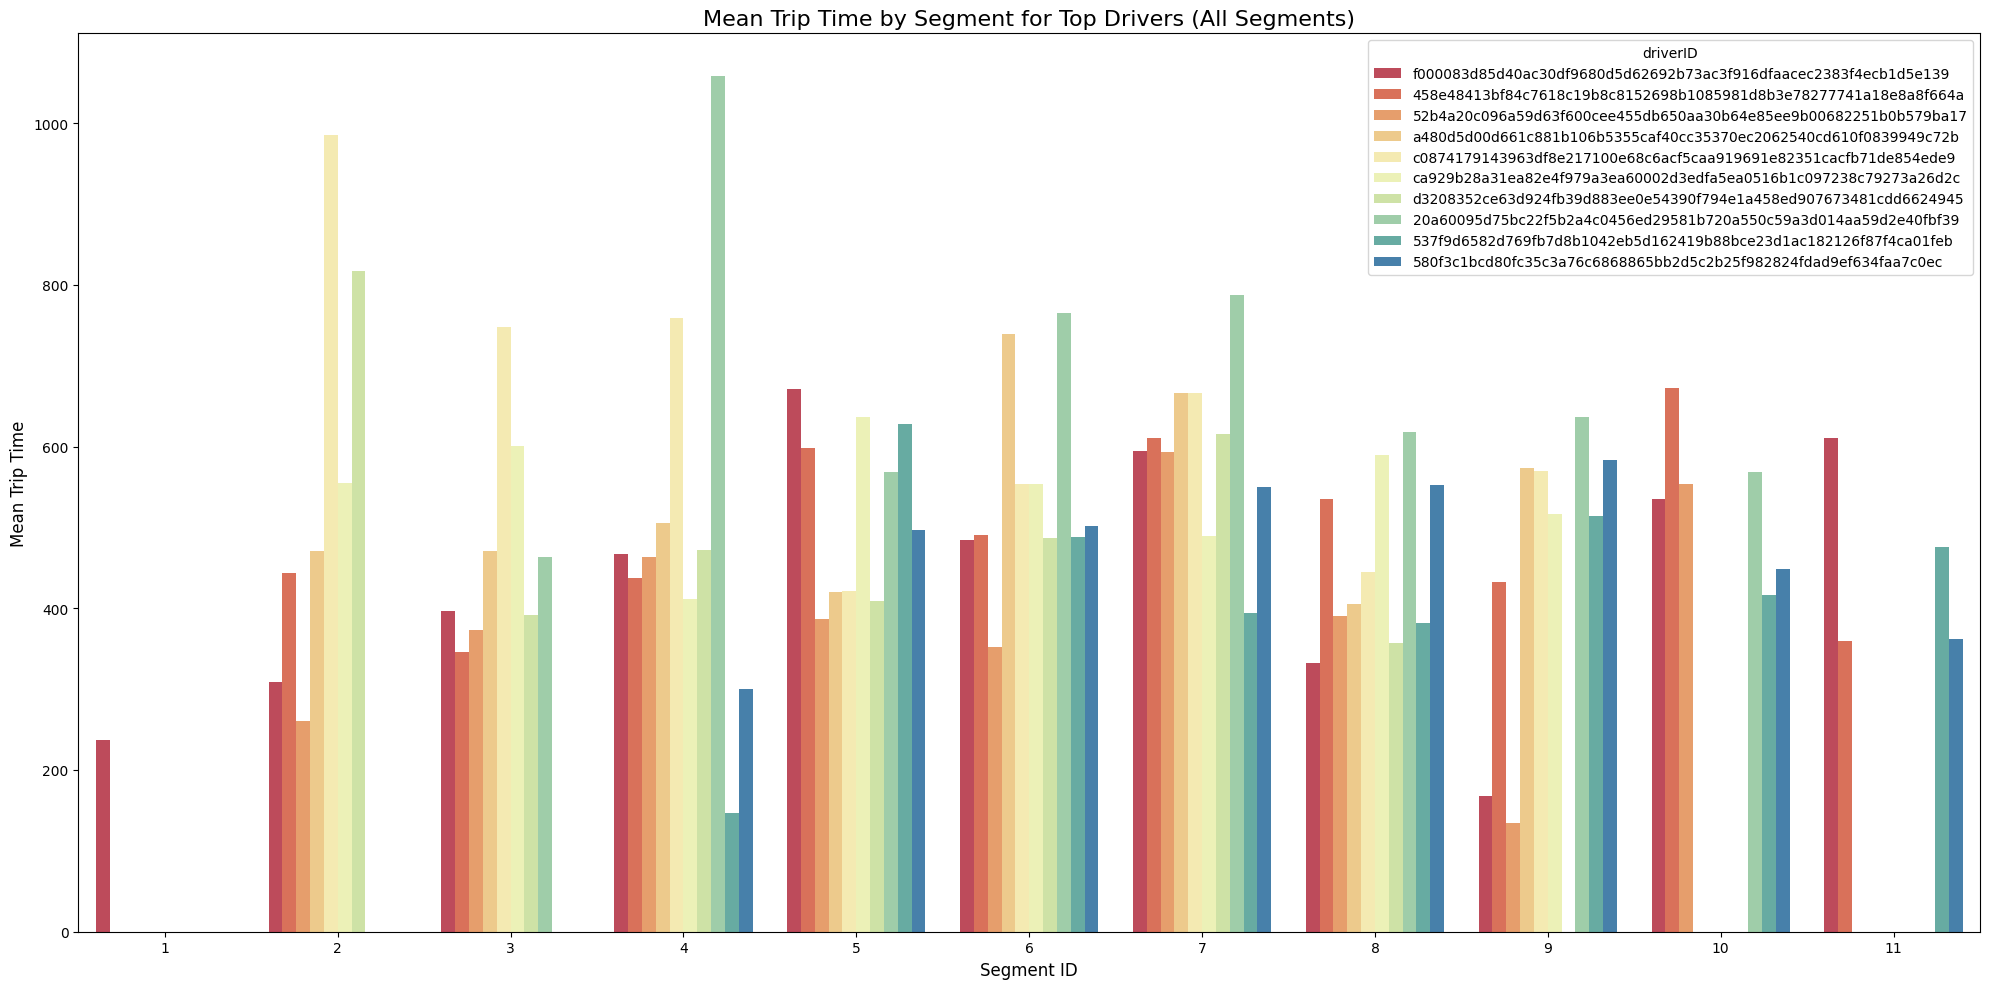

In [ ]:
# Use all unique segments instead of restricting to the top ones
unique_segments = road_df['two_hour_segment_encoded'].unique().tolist()

# Filter data for all unique segments
filtered_data = road_df[road_df['two_hour_segment_encoded'].isin(unique_segments)]

# Calculate mean trip time per driver and segment
driver_segment_means = (
    filtered_data.groupby(['driverID', 'two_hour_segment_encoded'])['trip_time']
    .mean()
    .reset_index()
)

# Get the top 10 drivers with the most trips
top_drivers = road_df['driverID'].value_counts().head(10).index.tolist()

# Filter for top drivers
driver_segment_means = driver_segment_means[driver_segment_means['driverID'].isin(top_drivers)]

# Plot
plt.figure(figsize=(20, 10))
sns.barplot(
    data=driver_segment_means,
    x='two_hour_segment_encoded',
    y='trip_time',
    hue='driverID',
    palette='Spectral'
)
plt.title('Mean Trip Time by Segment for Top Drivers (All Segments)', fontsize=16)
plt.xlabel('Segment ID', fontsize=12)
plt.ylabel('Mean Trip Time', fontsize=12)
# plt.legend(title='Driver ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
results = subset_data

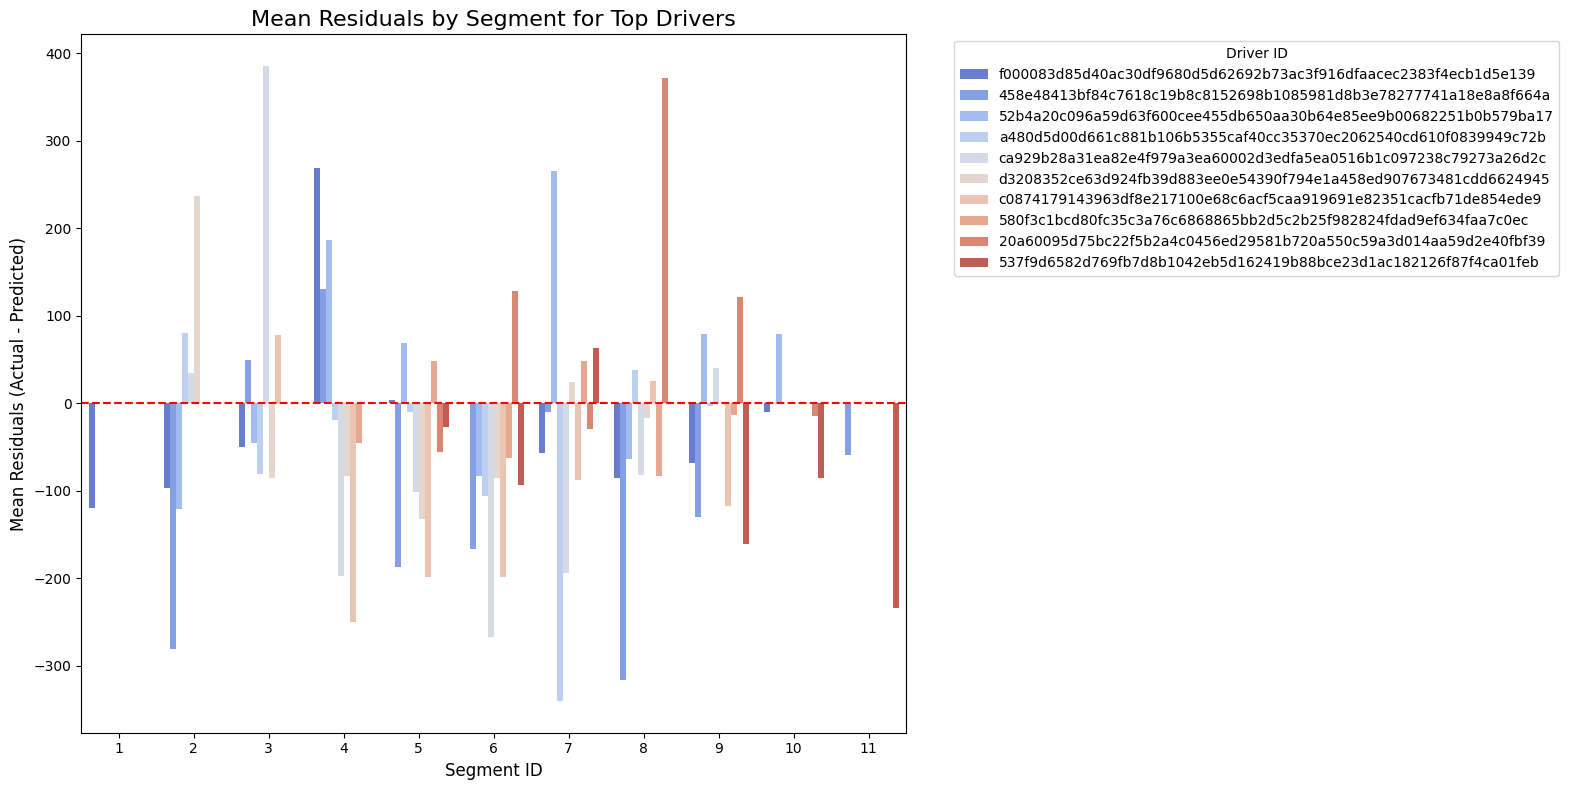

In [ ]:
# Add residuals to the results DataFrame
results['residuals'] = results['actual_eta'] - results['predicted_eta']

# Calculate residual statistics by driver and segment
residual_analysis = (
    results.merge(road_df[['trip_id', 'driverID', 'two_hour_segment_encoded']], on='trip_id')
    .groupby(['driverID', 'two_hour_segment_encoded'])['residuals']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)

# Filter for top drivers and top segments
residual_analysis = residual_analysis[
    residual_analysis['driverID'].isin(top_drivers) & residual_analysis['two_hour_segment_encoded'].isin(unique_segments)
]

# Plot residuals
plt.figure(figsize=(16, 8))
sns.barplot(
    data=residual_analysis,
    x='two_hour_segment_encoded',
    y='mean',
    hue='driverID',
    palette='coolwarm'
)
plt.title('Mean Residuals by Segment for Top Drivers', fontsize=16)
plt.xlabel('Segment ID', fontsize=12)
plt.ylabel('Mean Residuals (Actual - Predicted)', fontsize=12)
plt.axhline(0, color='red', linestyle='--')
plt.legend(title='Driver ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Encoding

In [ ]:
# Step 1: Compute Segment-Specific Statistics for Each Driver
segment_driver_stats = road_df.groupby(['two_hour_segment_encoded', 'driverID'])['trip_time'].agg(['mean', 'std']).reset_index()
segment_driver_stats.rename(columns={'mean': 'segment_mean_trip_time', 'std': 'segment_std_trip_time'}, inplace=True)

# Step 2: Merge Segment Statistics Back into the Main DataFrame
road_df = road_df.merge(segment_driver_stats, on=['two_hour_segment_encoded', 'driverID'], how='left')

# Step 3: Inspect the Resulting DataFrame
road_df[['driverID', 'two_hour_segment_encoded', 'segment_mean_trip_time', 'segment_std_trip_time']].head()


,driverID,two_hour_segment_encoded,segment_mean_trip_time,segment_std_trip_time
0,f08d6945b55252d6d92cbc2b7723a97b38c53fae3722fe...,5,421.857143,367.660363
1,512290052fa7f3409b5c25553ca1327fef779bcfa10f85...,10,648.500000,613.061579
2,512290052fa7f3409b5c25553ca1327fef779bcfa10f85...,10,648.500000,613.061579
3,151d782e218516dcf713a52fa47bf0afa4108c004f6c3d...,11,268.333333,84.109056
4,7ccad632b6ecd0119fc6904f56887d3e99ea6656d118cc...,6,748.333333,624.353466


In [ ]:
# Step 1: Compute Overall Statistics per Driver
driver_overall_stats = road_df.groupby('driverID')['trip_time'].agg(['mean', 'std', 'count']).reset_index()
driver_overall_stats.rename(columns={'mean': 'overall_mean_trip_time', 'std': 'overall_std_trip_time', 'count': 'trip_count'}, inplace=True)

# Step 2: Compute Weighted Features (Weight = Trip Count)
driver_overall_stats['weighted_mean_trip_time'] = driver_overall_stats['overall_mean_trip_time'] * driver_overall_stats['trip_count']
driver_overall_stats['weighted_std_trip_time'] = driver_overall_stats['overall_std_trip_time'] * driver_overall_stats['trip_count']

# Step 3: Merge Weighted Encoding Back into the Main DataFrame
road_df = road_df.merge(driver_overall_stats[['driverID', 'weighted_mean_trip_time', 'weighted_std_trip_time']], on='driverID', how='left')

# Step 4: Inspect the Resulting DataFrame
road_df[['driverID', 'weighted_mean_trip_time', 'weighted_std_trip_time']].head()


,driverID,weighted_mean_trip_time,weighted_std_trip_time
0,f08d6945b55252d6d92cbc2b7723a97b38c53fae3722fe...,22993.0,17039.553408
1,512290052fa7f3409b5c25553ca1327fef779bcfa10f85...,4880.0,4358.207757
2,512290052fa7f3409b5c25553ca1327fef779bcfa10f85...,4880.0,4358.207757
3,151d782e218516dcf713a52fa47bf0afa4108c004f6c3d...,29904.0,22048.506110
4,7ccad632b6ecd0119fc6904f56887d3e99ea6656d118cc...,28278.0,23755.216742


In [ ]:
road_df.shape

(64442, 36)

In [ ]:
road_df.to_csv('driver_road_df.csv', index=False)

### Encode the Temporal Patterns (Time Segment) to follow a Cyclic Nature
Use Cyclic Encoding

In [ ]:
import numpy as np

# Assuming two_hour_segment_encoded ranges from 0 to 11 (representing 12 segments in 24 hours)
max_segment_value = road_df['two_hour_segment_encoded'].max()

# Apply cyclical encoding (sin and cos transformations)
road_df['two_hour_segment_sin'] = np.sin(2 * np.pi * road_df['two_hour_segment_encoded'] / (max_segment_value + 1))
road_df['two_hour_segment_cos'] = np.cos(2 * np.pi * road_df['two_hour_segment_encoded'] / (max_segment_value + 1))

# Inspect the resulting cyclical encoding
road_df[['two_hour_segment_encoded', 'two_hour_segment_sin', 'two_hour_segment_cos']].head()


,two_hour_segment_encoded,two_hour_segment_sin,two_hour_segment_cos
0,5,5.000000e-01,-0.866025
1,10,-8.660254e-01,0.500000
2,10,-8.660254e-01,0.500000
3,11,-5.000000e-01,0.866025
4,6,1.224647e-16,-1.000000


In [ ]:
road_df[['two_hour_segment_encoded', 'two_hour_segment_sin', 'two_hour_segment_cos']].head(15)

,two_hour_segment_encoded,two_hour_segment_sin,two_hour_segment_cos
0,5,2.817326e-01,-0.959493
1,10,-5.406408e-01,0.841254
2,10,-5.406408e-01,0.841254
3,11,-1.133108e-15,1.000000
4,6,-2.817326e-01,-0.959493
5,6,-2.817326e-01,-0.959493
6,7,-7.557496e-01,-0.654861
7,7,-7.557496e-01,-0.654861
8,9,-9.096320e-01,0.415415
9,9,-9.096320e-01,0.415415


In [ ]:
result = road_df[road_df['two_hour_segment_encoded'] == 0]
result[['two_hour_segment_encoded', 'two_hour_segment_sin', 'two_hour_segment_cos']]


,two_hour_segment_encoded,two_hour_segment_sin,two_hour_segment_cos
60,0,0.0,1.0
61,0,0.0,1.0
279,0,0.0,1.0
280,0,0.0,1.0
732,0,0.0,1.0
...,...,...,...
64123,0,0.0,1.0
64124,0,0.0,1.0
64240,0,0.0,1.0
64241,0,0.0,1.0


In [ ]:
# show the columns 'two_hour_segment_encoded', 'two_hour_segment_sin', 'two_hour_segment_cos' for the unique values for two_hour_segment_encoded
result = road_df.groupby('two_hour_segment_encoded')[['two_hour_segment_encoded', 'two_hour_segment_sin', 'two_hour_segment_cos']].first()
result

,two_hour_segment_encoded,two_hour_segment_sin,two_hour_segment_cos
two_hour_segment_encoded,,,
0,0,0.000000e+00,1.000000e+00
1,1,5.000000e-01,8.660254e-01
2,2,8.660254e-01,5.000000e-01
3,3,1.000000e+00,6.123234e-17
4,4,8.660254e-01,-5.000000e-01
5,5,5.000000e-01,-8.660254e-01
6,6,1.224647e-16,-1.000000e+00
7,7,-5.000000e-01,-8.660254e-01
8,8,-8.660254e-01,-5.000000e-01


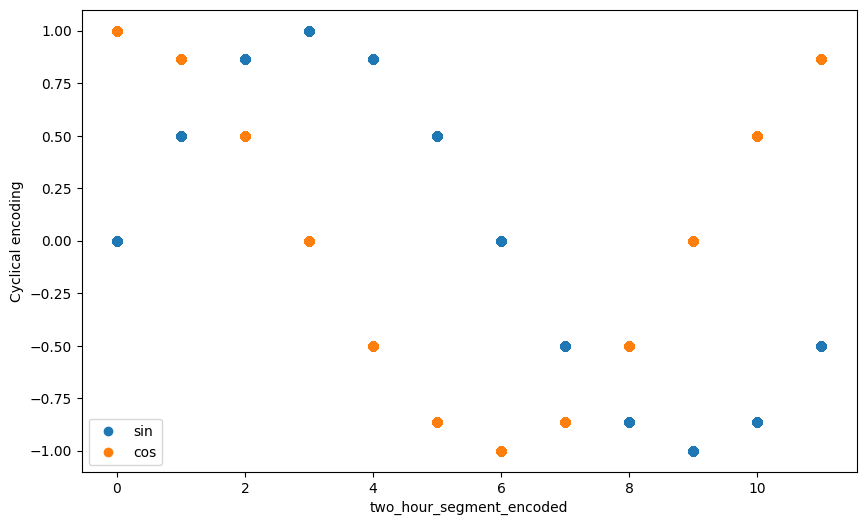

In [ ]:
# plot the cyclical encoding vs the two_hour_segment_encoded
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(road_df['two_hour_segment_encoded'], road_df['two_hour_segment_sin'], label='sin')
plt.scatter(road_df['two_hour_segment_encoded'], road_df['two_hour_segment_cos'], label='cos')
plt.xlabel('two_hour_segment_encoded')
plt.ylabel('Cyclical encoding')
plt.legend()
plt.show()


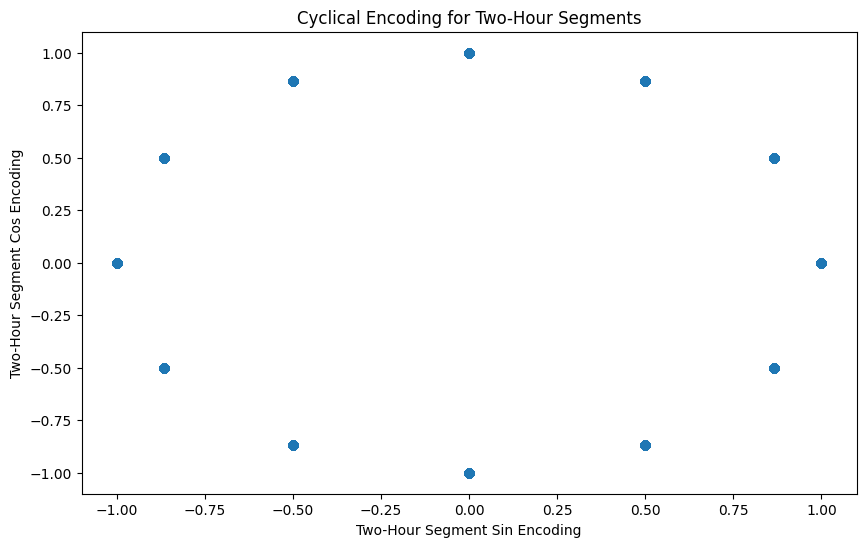

<module 'matplotlib.pyplot' from 'C:\\Users\\nadab\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:

# Plot the cyclical encoding for the two-hour segments
plt.figure(figsize=(10, 6))
plt.scatter(road_df['two_hour_segment_sin'], road_df['two_hour_segment_cos'])
plt.xlabel('Two-Hour Segment Sin Encoding')
plt.ylabel('Two-Hour Segment Cos Encoding')
plt.title('Cyclical Encoding for Two-Hour Segments')
plt.show()

# Plot the cyclical encoding for the two-hour segments
plt

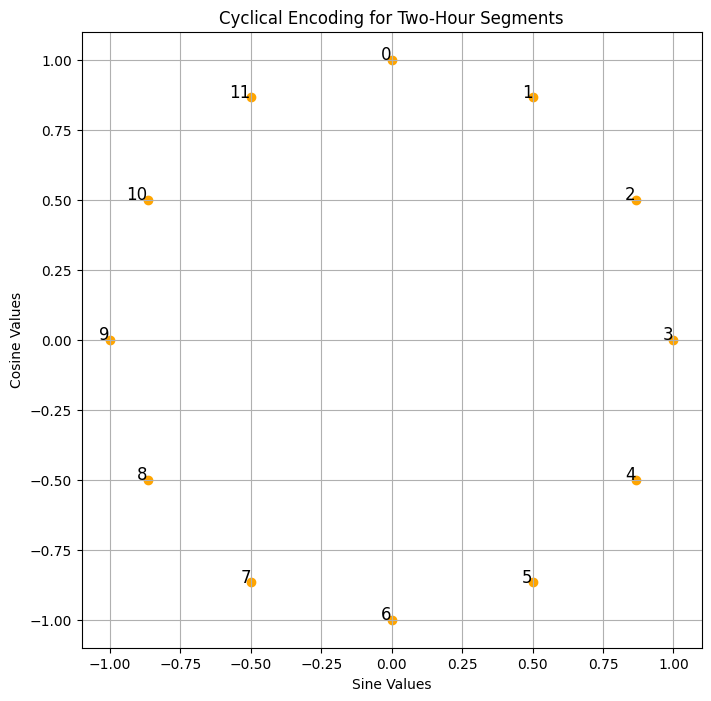

In [ ]:
import matplotlib.pyplot as plt

segments = np.arange(12)
sin_vals = np.sin(2 * np.pi * segments / 12)
cos_vals = np.cos(2 * np.pi * segments / 12)

plt.figure(figsize=(8, 8))
plt.scatter(sin_vals, cos_vals, color='orange')
plt.xlabel('Sine Values')
plt.ylabel('Cosine Values')
plt.title('Cyclical Encoding for Two-Hour Segments')
for i, (x, y) in enumerate(zip(sin_vals, cos_vals)):
    plt.text(x, y, f'{i}', fontsize=12, ha='right')
plt.grid()
plt.show()


#### Cyclic Encoding for weekday id

In [ ]:
# Cyclical encoding for weekID (7 days in a week)
road_df['weekID_sin'] = np.sin(2 * np.pi * road_df['weekID'] / 7)
road_df['weekID_cos'] = np.cos(2 * np.pi * road_df['weekID'] / 7)

# Display first rows
road_df[['weekID', 'weekID_sin', 'weekID_cos']].head()

,weekID,weekID_sin,weekID_cos
0,3,0.433884,-0.900969
1,3,0.433884,-0.900969
2,3,0.433884,-0.900969
3,3,0.433884,-0.900969
4,3,0.433884,-0.900969


In [ ]:
# show the columns 'two_hour_segment_encoded', 'two_hour_segment_sin', 'two_hour_segment_cos' for the unique values for two_hour_segment_encoded
result = road_df.groupby('weekID')[['weekID', 'weekID_sin', 'weekID_cos']].first()
result

,weekID,weekID_sin,weekID_cos
weekID,,,
0,0,0.000000,1.000000
1,1,0.781831,0.623490
2,2,0.974928,-0.222521
3,3,0.433884,-0.900969
4,4,-0.433884,-0.900969
5,5,-0.974928,-0.222521
6,6,-0.781831,0.623490


#### Cyclic Encoding for timeID

In [ ]:
road_df['timeID_sin'] = np.sin(2 * np.pi * road_df['timeID'] / 1440)
road_df['timeID_cos'] = np.cos(2 * np.pi * road_df['timeID'] / 1440)
# Cyclical encoding for timeID (1440 minutes in a day)

# Display first rows
road_df[['timeID', 'timeID_sin', 'timeID_cos']].head()


,timeID,timeID_sin,timeID_cos
0,708.7,0.049286,-0.998785
1,1290.0,-0.608761,0.793353
2,1296.9,-0.584604,0.811319
3,1379.1,-0.262610,0.964902
4,756.0,-0.156434,-0.987688


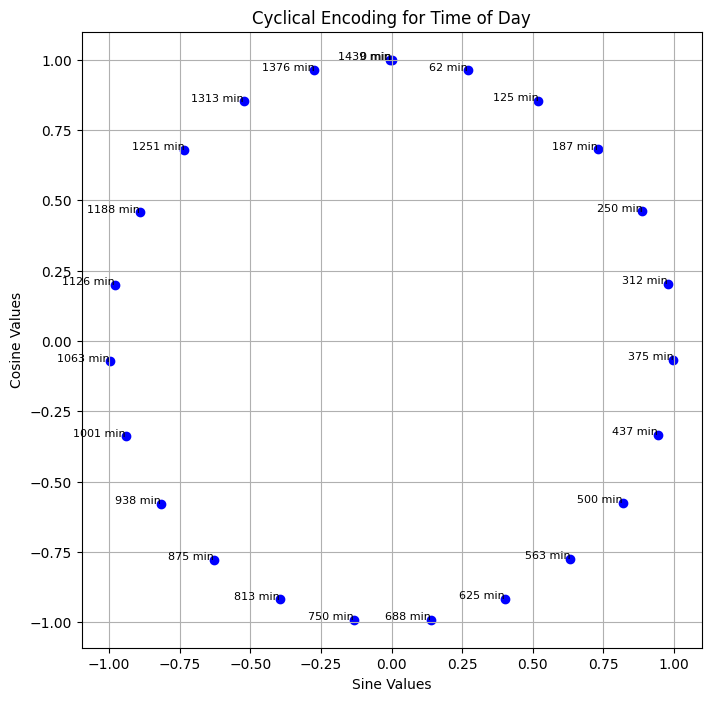

In [ ]:
# Visualization of timeID encoding (select representative times throughout the day)
time_minutes = np.linspace(0, 1439, num=24)  # 24 points representing every hour
sin_vals = np.sin(2 * np.pi * time_minutes / 1440)
cos_vals = np.cos(2 * np.pi * time_minutes / 1440)

plt.figure(figsize=(8, 8))
plt.scatter(sin_vals, cos_vals, color='blue')
plt.xlabel('Sine Values')
plt.ylabel('Cosine Values')
plt.title('Cyclical Encoding for Time of Day')
for i, (x, y) in enumerate(zip(sin_vals, cos_vals)):
    plt.text(x, y, f'{int(time_minutes[i])} min', fontsize=8, ha='right')
plt.grid()
plt.show()


### Create Interaction Terms between dist & time

In [ ]:
# Creating interaction terms between distance and time-related features
road_df['dist_timeID_interaction'] = road_df['dist'] * road_df['timeID']
road_df['dist_two_hour_segment_interaction'] = road_df['dist'] * road_df['two_hour_segment_encoded']

road_df[['dist', 'timeID', 'segmentID', 'two_hour_segment_encoded', 
         'dist_timeID_interaction', 'dist_segment_interaction', 
         'dist_two_hour_segment_interaction']].head()

In [ ]:
# Creating interaction terms
road_df['dist_segment_mean'] = road_df['dist'] * road_df['segment_mean_trip_time']
road_df['dist_segment_std'] = road_df['dist'] * road_df['segment_std_trip_time']
road_df['dist_time_cos'] = road_df['dist'] * road_df['timeID_cos']
road_df['dist_time_sin'] = road_df['dist'] * road_df['timeID_sin']
road_df['segment_mean_time_cos'] = road_df['segment_mean_trip_time'] * road_df['timeID_cos']
road_df['segment_mean_time_sin'] = road_df['segment_mean_trip_time'] * road_df['timeID_sin']

print("Interaction terms added successfully.")


Interaction terms added successfully.


In [ ]:
interaction_columns = ['dist_segment_mean', 'dist_segment_std', 'dist_time_cos', 'dist_time_sin', 
                       'segment_mean_time_cos', 'segment_mean_time_sin']

# Summary statistics for interaction terms
road_df[interaction_columns].describe()


,dist_segment_mean,dist_segment_std,dist_time_cos,dist_time_sin,segment_mean_time_cos,segment_mean_time_sin
count,64442.000000,62655.000000,64442.000000,64442.000000,64442.000000,64442.000000
mean,2225.259842,1591.909887,-1.051926,-1.358394,-187.685209,-198.283841
std,2785.854147,2163.379199,3.387208,3.519757,358.416537,361.998351
min,0.000000,0.000000,-19.425480,-19.761987,-2511.674803,-2431.501852
25%,400.745227,266.993225,-2.182814,-2.636353,-450.944525,-461.362305
50%,1174.561722,774.817518,-0.499407,-0.598998,-214.123593,-269.134952
75%,3055.812944,2078.817414,0.120530,0.106013,69.733753,64.145278
max,46057.199767,34038.703778,18.704972,19.172531,2080.941750,1662.718175


In [ ]:
road_df.to_csv('final_road_df.csv', index=False)

## STING RFR Modeling

In [ ]:
# load road_df from csv
road_df = pd.read_csv('final_road_df.csv')

In [ ]:
road_df.shape

(64442, 30)

In [ ]:
# Load the .pkl file
with open('best_hyperparameters.pkl', 'rb') as file:
    hyperparam = pickle.load(file)

print(hyperparam)


{'dbscan': {'n_estimators': np.int64(150), 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': None}, 'hierarchical': {'n_estimators': np.int64(150), 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': None}, 'sting': {'n_estimators': np.int64(150), 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': None}, 'clique': {'n_estimators': np.int64(150), 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': None}}


In [ ]:
road_df.columns

Index(['trip_id', 'time_gap', 'dist', 'trip_time', 'driverID', 'weekID',
       'timeID', 'dateID', 'dist_gap', 'lats', 'lngs', 'time_offset',
       'segmentID', 'two_hour_segment', 'hour', 'start_cluster', 'end_cluster',
       'start_cluster_dbscan', 'end_cluster_dbscan', 'same_cluster_dbscan',
       'start_cluster_sting', 'end_cluster_sting', 'same_cluster_sting',
       'start_cluster_clique', 'end_cluster_clique', 'same_cluster_clique',
       'start_cluster_hierarchical', 'end_cluster_hierarchical',
       'same_cluster_hierarchical', 'two_hour_segment_encoded'],
      dtype='object')

Training Set Metrics:
RMSE: 134.37989785079017
MAE: 88.9835880091477
R² Score: 0.9033676214095889

Testing Set Metrics:
RMSE: 195.30364931658042
MAE: 134.5996964276508
R² Score: 0.7955442182133842


Feature Importance for Sting Model:
                    feature  importance
6         dist_segment_mean    0.709256
7          dist_segment_std    0.154610
2    segment_mean_trip_time    0.026630
3     segment_std_trip_time    0.019154
0                      dist    0.012325
10    segment_mean_time_cos    0.011703
12      start_cluster_sting    0.011674
5    weighted_std_trip_time    0.009214
11    segment_mean_time_sin    0.008548
8             dist_time_cos    0.008232
13        end_cluster_sting    0.007904
4   weighted_mean_trip_time    0.007771
1                timeID_cos    0.006793
9             dist_time_sin    0.006186


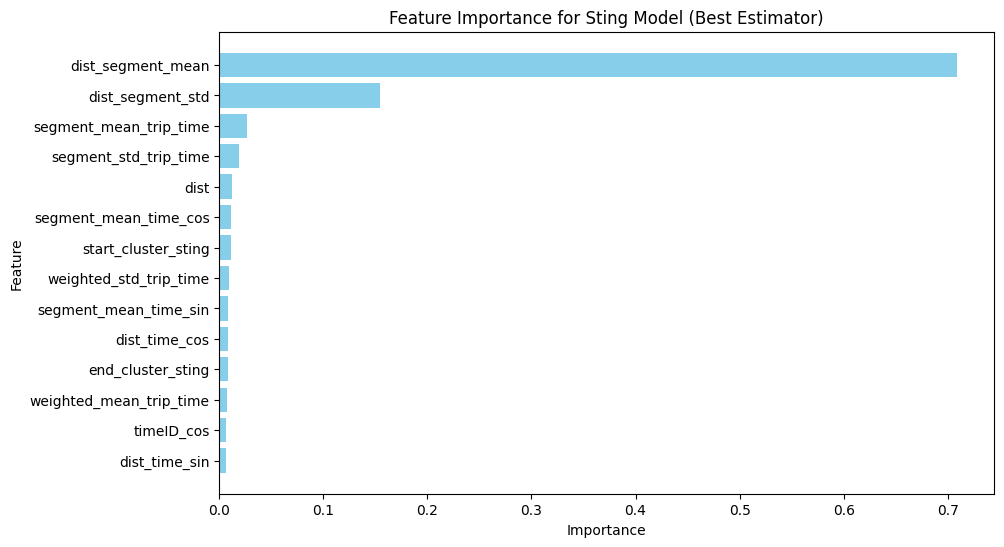

Results with trip IDs saved to sting_eta_rfr_predictions.csv
Trained model for Sting saved as RFR_Model_Weights_Driver_Cyclic.pkl


In [ ]:
feature_columns = ['dist', 'timeID_cos', 'segment_mean_trip_time', 'segment_std_trip_time', 'weighted_mean_trip_time', 'weighted_std_trip_time']

# add interaction terms to feature columns
feature_columns += interaction_columns

all_results = []  

# Define hyperparameter grid for Randomized Search
param_distributions = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

specific_features = feature_columns + [f'start_cluster_sting', f'end_cluster_sting']
target_column='trip_time'

# Define features and target (exclude trip_id from features but retain it for output)
X = road_df[specific_features]
y = road_df[target_column]
trip_ids = road_df['trip_id']  # Retain trip_id for traceability in the output

# Split data into training and testing sets, keeping trip_id with the test set
X_train, X_test, y_train, y_test, trip_id_train, trip_id_test = train_test_split(
    X, y, trip_ids, test_size=0.2, random_state=42
)

# Randomized Search for hyperparameter tuning
model = RandomForestRegressor(n_estimators=150, max_depth=None, min_samples_split=15, min_samples_leaf=4, random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for the training set
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for the testing set
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display the metrics
print("Training Set Metrics:")
print(f"RMSE: {train_rmse}")
print(f"MAE: {train_mae}")
print(f"R² Score: {train_r2}\n")

print("Testing Set Metrics:")
print(f"RMSE: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"R² Score: {test_r2}\n")



# Store the predictions and actual values along with trip_id for traceability
results = pd.DataFrame({
    'trip_id': trip_id_test,
    'actual_eta': y_test,
    'predicted_eta': y_test_pred,
    'algorithm': 'sting'
})


# Display feature importance
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': specific_features,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

print(f"\nFeature Importance for Sting Model:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importance for Sting Model (Best Estimator)')
plt.gca().invert_yaxis()  
plt.show()

output_csv = 'sting_eta_rfr_predictions.csv'
results.to_csv(output_csv, index=False)
print(f"Results with trip IDs saved to {output_csv}")

# save model weights
model_filename = 'RFR_Model_Weights_Driver_Cyclic.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)
print(f"Trained model for Sting saved as {model_filename}")


In [ ]:
# load model weights
with open('Final_RFR_Model_Weights.pkl', 'rb') as file:
    model = pickle.load(file)

print(model)

RandomForestRegressor(min_samples_leaf=4, min_samples_split=15,
                      n_estimators=150, random_state=42)


### Inspect Overfitting vs. Underfitting

#### Residual Plots

C:\Users\nadab\AppData\Local\Temp\ipykernel_10604\1696039688.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('third_train_results/residuals_vs_predicted_values.png')


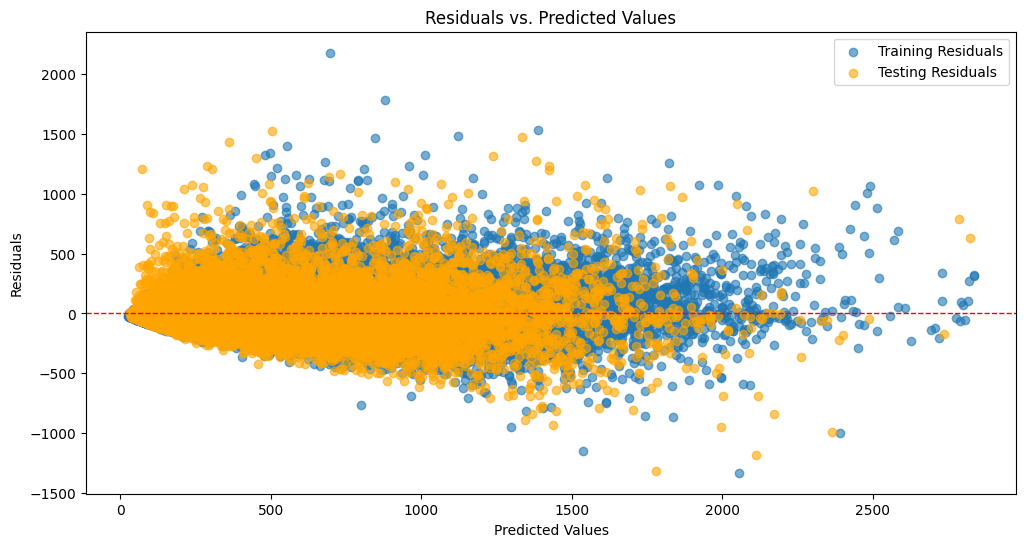

In [ ]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Plot residuals for training and testing sets
plt.figure(figsize=(12, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.6, label="Training Residuals")
plt.scatter(y_test_pred, test_residuals, alpha=0.6, label="Testing Residuals", color='orange')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.legend()
plt.savefig('third_train_results/residuals_vs_predicted_values.png')
plt.show()


#### Training vs. Testing Predictions

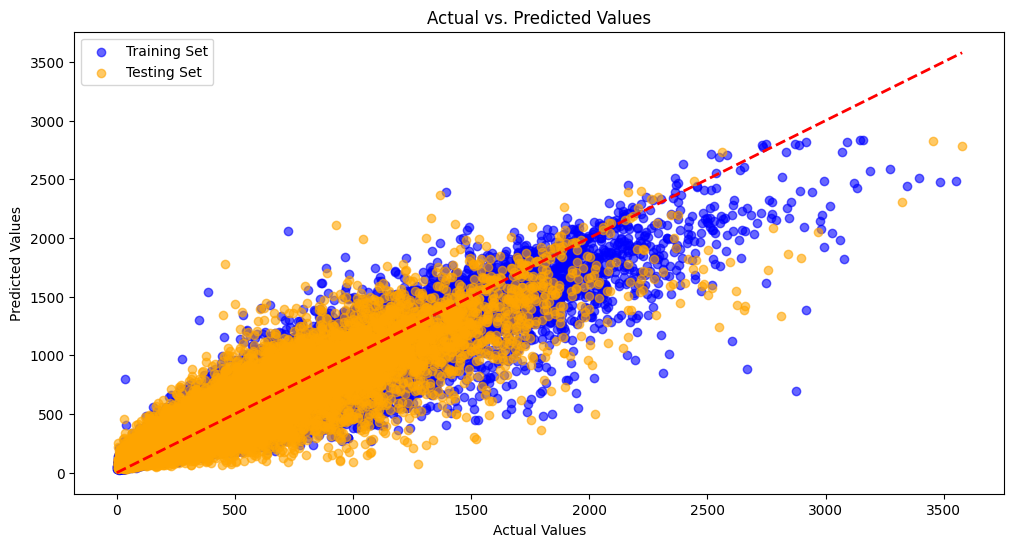

In [ ]:
# Plot actual vs. predicted values for training and testing sets
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, alpha=0.6, label="Training Set", color='blue')
plt.scatter(y_test, y_test_pred, alpha=0.6, label="Testing Set", color='orange')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)  # Ideal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.savefig('third_train_results/actual_vs_predicted_values.png')
plt.show()

#### Learning Curves

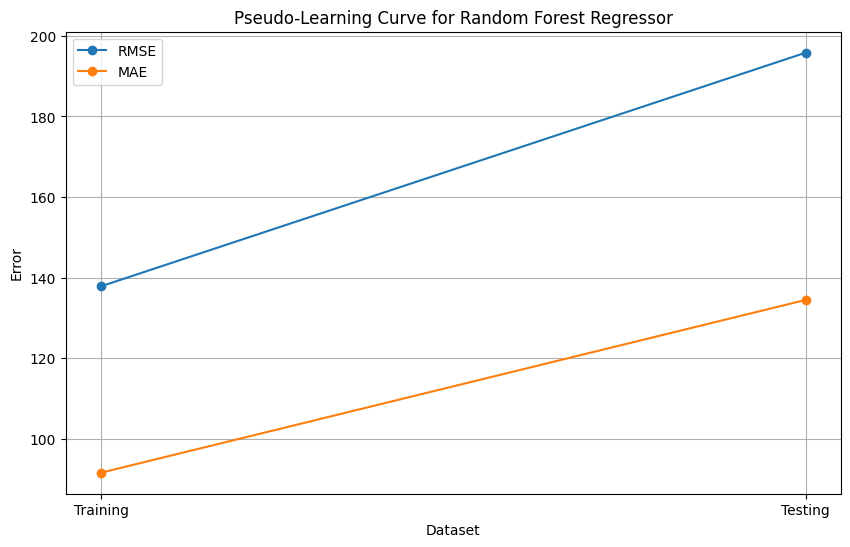

In [ ]:
# Plot pseudo-learning curve
plt.figure(figsize=(10, 6))
plt.plot(['Training', 'Testing'], [train_rmse, test_rmse], marker='o', label="RMSE")
plt.plot(['Training', 'Testing'], [train_mae, test_mae], marker='o', label="MAE")
plt.xlabel("Dataset")
plt.ylabel("Error")
plt.title("Pseudo-Learning Curve for Random Forest Regressor")
plt.legend()
plt.grid()
plt.savefig('third_train_results/pseudo_learning_curve.png')
plt.show()


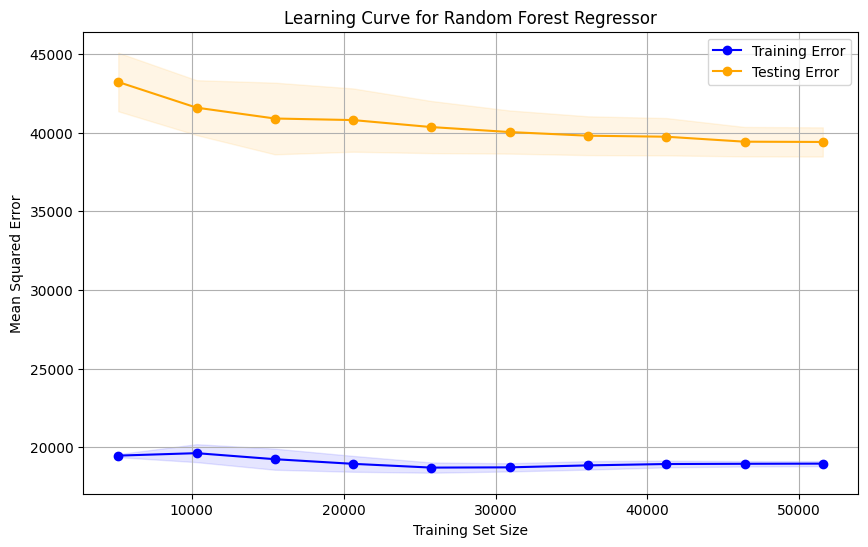

In [ ]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and std for training and testing scores
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label="Training Error")
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label="Testing Error")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 color='blue', alpha=0.1)
plt.fill_between(train_sizes,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 color='orange', alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve for Random Forest Regressor")
plt.legend()
plt.grid()
plt.savefig('third_train_results/learning_curve.png')
plt.show()
